<a href="https://colab.research.google.com/github/hashil7/Anomaly-Detection/blob/main/Copy_of_final_ml_project_4_11_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
#Size of our input images
SIZE = 128

#############################################################################
#Define generators for training, validation and also anomaly data.

batch_size = 64

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)
#m='My Drive/combined/uninfected_train/images'
#print(len(m))
train_generator = datagen.flow_from_directory(
    r'/content/drive/MyDrive/combined/Uninfected/new_uinfected/train_images',
    target_size=(SIZE,SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

validation_generator = datagen.flow_from_directory(
    r"/content/drive/MyDrive/combined/Validation_uinfected",
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )
anomaly_generator = datagen.flow_from_directory(
    r'/content/drive/MyDrive/combined/Uninfected/new_uinfected/test_1',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )


Found 721 images belonging to 1 classes.
Found 5 images belonging to 1 classes.
Found 309 images belonging to 1 classes.


In [ ]:
from keras.models import load_model
loaded_model=load_model('/content/drive/MyDrive/combined/mml_models/final_ml.h5')

2/2 [==============================] - 8s 10ms/step


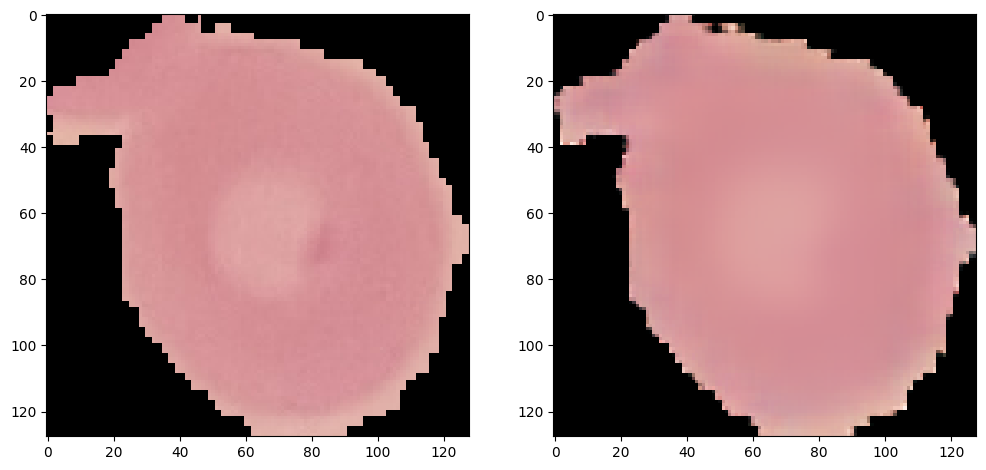

<ipython-input-5-577933ced4cb>:24: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  validation_error = loaded_model.evaluate_generator(validation_generator)
<ipython-input-5-577933ced4cb>:25: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  anomaly_error = loaded_model.evaluate_generator(anomaly_generator)


Recon. error for the validation (normal) data is:  [0.000674193724989891, 0.000674193724989891]
Recon. error for the anomaly data is:  [0.0012014704989269376, 0.0012014704989269376]


In [ ]:
# Get all batches generated by the datagen and pick a batch for prediction
#Just to test the model.
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1

predicted = loaded_model.predict(data_batch[0])  #Predict on the first batch of images


#Sanity check, view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()

#Let us examine the reconstruction error between our validation data (good/normal images)
# and the anomaly images
validation_error = loaded_model.evaluate_generator(validation_generator)
anomaly_error = loaded_model.evaluate_generator(anomaly_generator)

print("Recon. error for the validation (normal) data is: ", validation_error)
print("Recon. error for the anomaly data is: ", anomaly_error)

In [ ]:
#Let us extract (or build) the encoder network, with trained weights.
#This is used to get the compressed output (latent space) of the input image.
#The compressed output is then used to calculate the KDE

encoder_model = Sequential()
encoder_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3), weights=loaded_model.layers[0].get_weights()) )
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', weights=loaded_model.layers[2].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', weights=loaded_model.layers[4].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 16)        0

In [ ]:
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity

#Get encoded output of input images = Latent space
encoded_images = encoder_model.predict_generator(train_generator)




<ipython-input-7-2aeff019090f>:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  encoded_images = encoder_model.predict_generator(train_generator)


In [ ]:
# Flatten the encoder output because KDE from sklearn takes 1D vectors as input
encoder_output_shape = encoder_model.output_shape #Here, we have 16x16x16
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

In [ ]:
#Fit KDE to the image latent data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)

#Calculate density and reconstruction error to find their means values for
#good and anomaly images.
#We use these mean and sigma to set thresholds.
def calc_density_and_recon_error(batch_images):

    density_list=[]
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]-1):

        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        encoded_img = encoder_model.predict([[img]]) # Create a compressed version of the image using the encoder
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] # Flatten the compressed image
        density = kde.score_samples(encoded_img)[0] # get a density score for the new image
        reconstruction = loaded_model.predict([[img]])
        reconstruction_error = loaded_model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
        density_list.append(density)
        recon_error_list.append(reconstruction_error)

    average_density = np.mean(np.array(density_list))
    stdev_density = np.std(np.array(density_list))

    average_recon_error = np.mean(np.array(recon_error_list))
    stdev_recon_error = np.std(np.array(recon_error_list))

    return average_density, stdev_density, average_recon_error, stdev_recon_error

In [ ]:
#Get average and std dev. of density and recon. error for uninfected and anomaly (parasited) images.
#For this let us generate a batch of images for each.
train_batch = train_generator.next()[0]
anomaly_batch = anomaly_generator.next()[0]

uninfected_values = calc_density_and_recon_error(train_batch)
anomaly_values = calc_density_and_recon_error(anomaly_batch)


1/1 [==============================] - 0s 24ms/step - loss: 0.0047 - mse: 0.0047


In [ ]:
def print_uninfected_values(uninfected_values):
    print("Average Density:", uninfected_values[0])
    print("Standard Deviation of Density:", uninfected_values[1])
    print("Average Reconstruction Error:", uninfected_values[2])
    print("Standard Deviation of Reconstruction Error:", uninfected_values[3])



In [ ]:
print("Uninfected Values:")
print_uninfected_values(uninfected_values)

Uninfected Values:
Average Density: 2821.7048181864493
Standard Deviation of Density: 1.3642420526593924e-12
Average Reconstruction Error: 0.0017628758574747259
Standard Deviation of Reconstruction Error: 0.000848129144687293


In [ ]:
print("Anomaly Values:")
print_uninfected_values(anomaly_values)

Anomaly Values:
Average Density: -4109.50967197509
Standard Deviation of Density: 7533.701817809065
Average Reconstruction Error: 0.0022410075318822194
Standard Deviation of Reconstruction Error: 0.0009728855736603886


In [ ]:
#Now, input unknown images and sort as Good or Anomaly
d=[]
def check_anomaly(img_path):
    density_threshold = [2775] #Set this value based on the above exercise
    reconstruction_error_threshold = [0.00345] # Set this value based on the above exercise
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.ANTIALIAS))
    plt.imshow(img)
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    encoded_img = encoder_model.predict([[img]])
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img]
    density = kde.score_samples(encoded_img)[0]

    reconstruction = loaded_model.predict([[img]])
    reconstruction_error = loaded_model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
    for i in range(len(density_threshold)):
      for j in range(len(reconstruction_error_threshold)):
        if density < density_threshold[i] or reconstruction_error > reconstruction_error_threshold[j]:
            print("The image is an anomaly")
            d.append(0)

        else:
            print("The image is NOT an anomaly")
            d.append(1)



In [ ]:
import glob
para_file_paths = glob.glob('/content/drive/MyDrive/combined/Uninfected/new_uinfected/train_images/images/*')
uninfected_file_paths = glob.glob('/content/drive/MyDrive/combined/Uninfected/new_uinfected/test_1/images/*')

1/1 [==============================] - 0s 27ms/step


<ipython-input-37-39822897aeb0>:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0023 - mse: 0.0023
The image is NOT an anomaly


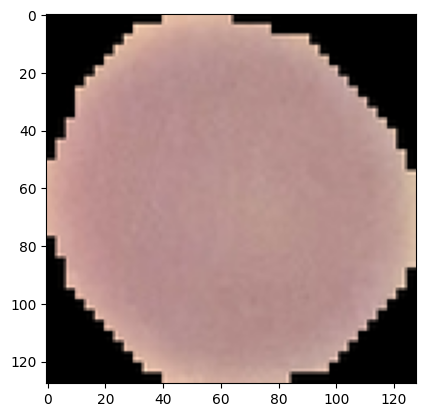

In [ ]:
#Good/normal image verification
num=random.randint(0,len(uninfected_file_paths)-1)
check_anomaly(uninfected_file_paths[num])

In [ ]:
num = 0;

1/1 [==============================] - 0s 17ms/step


<ipython-input-37-39822897aeb0>:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0027 - mse: 0.0027
The image is NOT an anomaly
30


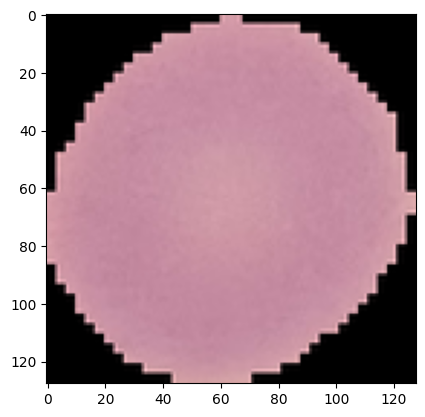

In [ ]:

num = num+1

check_anomaly(uninfected_file_paths[num])
print(num)

In [ ]:
#del y_pred1
#del y_pred2

In [ ]:
y_pred1=[]
y_pred2=[]

In [ ]:
from sklearn.metrics import f1_score,classification_report


def test_anomaly(img_path):
    density_threshold = [2400] #Set this value based on the above exercise
    reconstruction_error_threshold = 0.00282 # Set this value based on the above exercise
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.ANTIALIAS))
   # plt.imshow(img)
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    encoded_img = encoder_model.predict([[img]])
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img]
    density = kde.score_samples(encoded_img)[0]

    reconstruction = loaded_model.predict([[img]])
    reconstruction_error = loaded_model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
    #for i in range(len(density_threshold)):
      #for j in range(len(reconstruction_error_threshold)):
    # if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
   # if  (density >(density_threshold[0]-32) and density <(density_threshold[0]+5)) or reconstruction_error <=0.0022 :
    if reconstruction_error<=0.0022:
      y_pred1.append(1)
    else:
      y_pred1.append(0)
    # if density<density_threshold[1] or reconstruction_error>reconstruction_error_threshold:
    #   y_pred2.append(0)
    # else:
    #   y_pred2.append(1)

In [ ]:
from sklearn.metrics import f1_score,classification_report


def test_anomaly(img_path):
    density_threshold = [2775] #Set this value based on the above exercise
    reconstruction_error_threshold = 0.00345 # Set this value based on the above exercise
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.ANTIALIAS))
   # plt.imshow(img)
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    encoded_img = encoder_model.predict([[img]])
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img]
    density = kde.score_samples(encoded_img)[0]

    reconstruction = loaded_model.predict([[img]])
    reconstruction_error = loaded_model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
    #for i in range(len(density_threshold)):
      #for j in range(len(reconstruction_error_threshold)):
    # if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
    if  density < density_threshold[0] or reconstruction_error > reconstruction_error_threshold:
      y_pred1.append(0)
    else:
      y_pred1.append(1)
    # if density<density_threshold[1] or reconstruction_error>reconstruction_error_threshold:
    #   y_pred2.append(0)
    # else:
    #   y_pred2.append(1)

In [ ]:
len(para_file_paths)

721

In [ ]:
y_pred1=[]
y_pred2=[]
i =0;
img_path=para_file_paths
num =len(para_file_paths)

for i in range(num):
#for i in range(len(para_file_paths)-100):
#for i in range(40):
  print(i)
  test_anomaly(img_path[i])

0
1/1 [==============================] - 0s 31ms/step - loss: 0.0038 - mse: 0.0038


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1
1/1 [==============================] - 0s 26ms/step - loss: 0.0030 - mse: 0.0030


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


2
1/1 [==============================] - 0s 25ms/step - loss: 0.0036 - mse: 0.0036
3


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0047 - mse: 0.0047
4
1/1 [==============================] - 0s 25ms/step - loss: 0.0031 - mse: 0.0031
5


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 9.7649e-04 - mse: 9.7649e-04
6
1/1 [==============================] - 0s 27ms/step - loss: 0.0022 - mse: 0.0022
7


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 56ms/step - loss: 0.0033 - mse: 0.0033
8
1/1 [==============================] - 0s 25ms/step - loss: 0.0053 - mse: 0.0053


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


9
1/1 [==============================] - 0s 23ms/step - loss: 0.0032 - mse: 0.0032
10
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0029 - mse: 0.0029
11
1/1 [==============================] - 0s 25ms/step - loss: 0.0025 - mse: 0.0025


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


12
1/1 [==============================] - 0s 25ms/step - loss: 0.0037 - mse: 0.0037


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


13
1/1 [==============================] - 0s 26ms/step - loss: 0.0034 - mse: 0.0034
14
1/1 [==============================] - 0s 25ms/step - loss: 0.0018 - mse: 0.0018
15


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0021 - mse: 0.0021
16
1/1 [==============================] - 0s 25ms/step - loss: 0.0036 - mse: 0.0036


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


17
1/1 [==============================] - 0s 26ms/step - loss: 0.0039 - mse: 0.0039


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


18
1/1 [==============================] - 0s 27ms/step - loss: 0.0035 - mse: 0.0035


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


19
1/1 [==============================] - 0s 28ms/step - loss: 0.0052 - mse: 0.0052
20


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step - loss: 0.0027 - mse: 0.0027
21
1/1 [==============================] - 0s 24ms/step - loss: 0.0028 - mse: 0.0028
22


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0036 - mse: 0.0036


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


23
1/1 [==============================] - 0s 26ms/step - loss: 0.0024 - mse: 0.0024


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


24
1/1 [==============================] - 0s 24ms/step - loss: 0.0035 - mse: 0.0035
25


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0031 - mse: 0.0031
26
1/1 [==============================] - ETA: 0s - loss: 0.0033 - mse: 0.0033

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0033 - mse: 0.0033
27
1/1 [==============================] - 0s 24ms/step - loss: 0.0030 - mse: 0.0030
28


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0042 - mse: 0.0042
29
1/1 [==============================] - 0s 23ms/step - loss: 0.0018 - mse: 0.0018
30


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step - loss: 0.0051 - mse: 0.0051
31
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step - loss: 0.0040 - mse: 0.0040
32
1/1 [==============================] - 0s 34ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0045 - mse: 0.0045
33
1/1 [==============================] - 0s 26ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0029 - mse: 0.0029
34
1/1 [==============================] - 0s 32ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0027 - mse: 0.0027
35
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0030 - mse: 0.0030
36
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0035 - mse: 0.0035
37
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0022 - mse: 0.0022
38
1/1 [==============================] - 0s 39ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0012 - mse: 0.0012
39
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0014 - mse: 0.0014
40
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0035 - mse: 0.0035
41
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0037 - mse: 0.0037
42
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0025 - mse: 0.0025
43
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0023 - mse: 0.0023
44
1/1 [==============================] - 0s 26ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0033 - mse: 0.0033
45
1/1 [==============================] - 0s 28ms/step - loss: 0.0036 - mse: 0.0036


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


46
1/1 [==============================] - 0s 26ms/step - loss: 0.0028 - mse: 0.0028


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


47
1/1 [==============================] - 0s 25ms/step - loss: 0.0036 - mse: 0.0036
48


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0039 - mse: 0.0039
49
1/1 [==============================] - 0s 25ms/step - loss: 0.0035 - mse: 0.0035
50


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0039 - mse: 0.0039
51
1/1 [==============================] - 0s 28ms/step - loss: 0.0040 - mse: 0.0040


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


52
1/1 [==============================] - 0s 27ms/step - loss: 0.0031 - mse: 0.0031
53


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0028 - mse: 0.0028
54
1/1 [==============================] - 0s 26ms/step - loss: 0.0031 - mse: 0.0031
55


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0048 - mse: 0.0048
56
1/1 [==============================] - 0s 27ms/step - loss: 0.0027 - mse: 0.0027


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


57
1/1 [==============================] - 0s 25ms/step - loss: 0.0038 - mse: 0.0038


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


58
1/1 [==============================] - 0s 25ms/step - loss: 0.0043 - mse: 0.0043
59


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0022 - mse: 0.0022
60
1/1 [==============================] - 0s 25ms/step - loss: 0.0032 - mse: 0.0032


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


61
1/1 [==============================] - 0s 29ms/step - loss: 0.0032 - mse: 0.0032
62
1/1 [==============================] - 0s 24ms/step - loss: 0.0019 - mse: 0.0019
63


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0023 - mse: 0.0023
64
1/1 [==============================] - 0s 24ms/step - loss: 0.0028 - mse: 0.0028
65


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0065 - mse: 0.0065
66
1/1 [==============================] - 0s 24ms/step - loss: 0.0026 - mse: 0.0026
67


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0040 - mse: 0.0040
68
1/1 [==============================] - 0s 23ms/step - loss: 0.0031 - mse: 0.0031
69


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0046 - mse: 0.0046
70
1/1 [==============================] - 0s 25ms/step - loss: 0.0024 - mse: 0.0024
71


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0024 - mse: 0.0024
72
1/1 [==============================] - ETA: 0s - loss: 0.0024 - mse: 0.0024

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0024 - mse: 0.0024
73
1/1 [==============================] - 0s 25ms/step - loss: 0.0032 - mse: 0.0032


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


74
1/1 [==============================] - 0s 25ms/step - loss: 0.0031 - mse: 0.0031


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


75
1/1 [==============================] - 0s 25ms/step - loss: 0.0046 - mse: 0.0046
76


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0021 - mse: 0.0021

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0021 - mse: 0.0021
77
1/1 [==============================] - 0s 24ms/step - loss: 0.0022 - mse: 0.0022
78


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0019 - mse: 0.0019
79
1/1 [==============================] - 0s 29ms/step - loss: 0.0049 - mse: 0.0049


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


80
1/1 [==============================] - 0s 26ms/step - loss: 0.0024 - mse: 0.0024


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


81
1/1 [==============================] - 0s 25ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0022 - mse: 0.0022
82
1/1 [==============================] - 0s 24ms/step - loss: 0.0022 - mse: 0.0022
83


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0026 - mse: 0.0026
84
1/1 [==============================] - 0s 24ms/step - loss: 0.0041 - mse: 0.0041
85


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0036 - mse: 0.0036
86
1/1 [==============================] - ETA: 0s - loss: 0.0045 - mse: 0.0045

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0045 - mse: 0.0045
87
1/1 [==============================] - 0s 28ms/step - loss: 0.0041 - mse: 0.0041
88


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0029 - mse: 0.0029
89
1/1 [==============================] - 0s 27ms/step - loss: 0.0037 - mse: 0.0037


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


90
1/1 [==============================] - 0s 24ms/step - loss: 0.0023 - mse: 0.0023
91


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0042 - mse: 0.0042
92
1/1 [==============================] - 0s 25ms/step - loss: 0.0044 - mse: 0.0044
93


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0014 - mse: 0.0014
94
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0025 - mse: 0.0025
95
1/1 [==============================] - 0s 33ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0020 - mse: 0.0020
96
1/1 [==============================] - 0s 31ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0023 - mse: 0.0023
97
1/1 [==============================] - 0s 31ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0039 - mse: 0.0039
98
1/1 [==============================] - 0s 31ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0019 - mse: 0.0019
99
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0029 - mse: 0.0029
100
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0044 - mse: 0.0044
101
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step - loss: 0.0027 - mse: 0.0027
102
1/1 [==============================] - 0s 36ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0036 - mse: 0.0036
103
1/1 [==============================] - 0s 44ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step - loss: 0.0021 - mse: 0.0021
104
1/1 [==============================] - 0s 44ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step - loss: 0.0031 - mse: 0.0031
105
1/1 [==============================] - 0s 41ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step - loss: 0.0024 - mse: 0.0024
106
1/1 [==============================] - 0s 52ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step - loss: 0.0016 - mse: 0.0016
107
1/1 [==============================] - 0s 54ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step - loss: 0.0037 - mse: 0.0037
108
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0023 - mse: 0.0023
109
1/1 [==============================] - 0s 28ms/step - loss: 0.0041 - mse: 0.0041


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


110
1/1 [==============================] - 0s 25ms/step - loss: 0.0017 - mse: 0.0017
111
1/1 [==============================] - 0s 24ms/step - loss: 0.0040 - mse: 0.0040
112


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0024 - mse: 0.0024
113
1/1 [==============================] - ETA: 0s - loss: 0.0026 - mse: 0.0026

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0026 - mse: 0.0026
114
1/1 [==============================] - 0s 30ms/step - loss: 0.0031 - mse: 0.0031


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


115
1/1 [==============================] - 0s 28ms/step - loss: 0.0044 - mse: 0.0044
116


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0034 - mse: 0.0034
117
1/1 [==============================] - 0s 26ms/step - loss: 0.0031 - mse: 0.0031
118


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0038 - mse: 0.0038
119
1/1 [==============================] - ETA: 0s - loss: 0.0035 - mse: 0.0035

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0035 - mse: 0.0035
120
1/1 [==============================] - ETA: 0s - loss: 0.0046 - mse: 0.0046

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0046 - mse: 0.0046
121
1/1 [==============================] - 0s 30ms/step - loss: 0.0014 - mse: 0.0014
122


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0034 - mse: 0.0034
123
1/1 [==============================] - 0s 25ms/step - loss: 0.0026 - mse: 0.0026


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


124
1/1 [==============================] - 0s 27ms/step - loss: 0.0023 - mse: 0.0023


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


125
1/1 [==============================] - 0s 27ms/step - loss: 0.0022 - mse: 0.0022


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


126
1/1 [==============================] - 0s 27ms/step - loss: 0.0016 - mse: 0.0016
127


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0028 - mse: 0.0028
128
1/1 [==============================] - ETA: 0s - loss: 0.0030 - mse: 0.0030

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0030 - mse: 0.0030
129
1/1 [==============================] - 0s 32ms/step - loss: 0.0037 - mse: 0.0037
130


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0032 - mse: 0.0032
131
1/1 [==============================] - 0s 25ms/step - loss: 0.0035 - mse: 0.0035


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


132
1/1 [==============================] - 0s 33ms/step - loss: 0.0049 - mse: 0.0049
133


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0058 - mse: 0.0058
134
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0034 - mse: 0.0034
135
1/1 [==============================] - 0s 25ms/step - loss: 0.0023 - mse: 0.0023
136


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0039 - mse: 0.0039
137
1/1 [==============================] - 0s 27ms/step - loss: 0.0038 - mse: 0.0038


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


138
1/1 [==============================] - 0s 27ms/step - loss: 0.0021 - mse: 0.0021


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


139
1/1 [==============================] - 0s 34ms/step - loss: 0.0015 - mse: 0.0015


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


140
1/1 [==============================] - 0s 26ms/step - loss: 0.0048 - mse: 0.0048


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


141
1/1 [==============================] - 0s 28ms/step - loss: 0.0030 - mse: 0.0030
142
1/1 [==============================] - 0s 32ms/step - loss: 0.0031 - mse: 0.0031


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


143
1/1 [==============================] - ETA: 0s - loss: 0.0026 - mse: 0.0026

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0026 - mse: 0.0026
144
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0030 - mse: 0.0030
145
1/1 [==============================] - 0s 25ms/step - loss: 0.0043 - mse: 0.0043
146


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0035 - mse: 0.0035
147
1/1 [==============================] - 0s 35ms/step - loss: 0.0025 - mse: 0.0025


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


148
1/1 [==============================] - 0s 26ms/step - loss: 0.0022 - mse: 0.0022
149


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0042 - mse: 0.0042
150
1/1 [==============================] - ETA: 0s - loss: 0.0025 - mse: 0.0025

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0025 - mse: 0.0025
151
1/1 [==============================] - 0s 26ms/step - loss: 0.0028 - mse: 0.0028
152


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0030 - mse: 0.0030
153
1/1 [==============================] - 0s 25ms/step - loss: 0.0029 - mse: 0.0029
154


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0032 - mse: 0.0032
155
1/1 [==============================] - 0s 27ms/step - loss: 0.0015 - mse: 0.0015


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


156
1/1 [==============================] - 0s 44ms/step - loss: 0.0024 - mse: 0.0024


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


157
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0025 - mse: 0.0025
158
1/1 [==============================] - ETA: 0s

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step - loss: 0.0032 - mse: 0.0032
159
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0057 - mse: 0.0057
160
1/1 [==============================] - 0s 38ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0018 - mse: 0.0018
161
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0044 - mse: 0.0044
162
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0030 - mse: 0.0030
163
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0030 - mse: 0.0030
164
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0033 - mse: 0.0033
165
1/1 [==============================] - 0s 33ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0053 - mse: 0.0053
166
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step - loss: 0.0043 - mse: 0.0043
167
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0017 - mse: 0.0017
168
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0049 - mse: 0.0049
169
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0041 - mse: 0.0041
170
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step - loss: 0.0028 - mse: 0.0028
171
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0031 - mse: 0.0031
172
1/1 [==============================] - 0s 26ms/step - loss: 0.0041 - mse: 0.0041


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


173
1/1 [==============================] - 0s 24ms/step - loss: 0.0033 - mse: 0.0033


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


174
1/1 [==============================] - 0s 27ms/step - loss: 0.0059 - mse: 0.0059


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


175
1/1 [==============================] - 0s 28ms/step - loss: 0.0020 - mse: 0.0020
176


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0032 - mse: 0.0032
177
1/1 [==============================] - 0s 23ms/step - loss: 0.0044 - mse: 0.0044
178


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0025 - mse: 0.0025
179


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0047 - mse: 0.0047
180
1/1 [==============================] - 0s 24ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0013 - mse: 0.0013
181
1/1 [==============================] - 0s 25ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0030 - mse: 0.0030
182
1/1 [==============================] - 0s 23ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0045 - mse: 0.0045
183
1/1 [==============================] - 0s 24ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0036 - mse: 0.0036
184
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0024 - mse: 0.0024
185
1/1 [==============================] - 0s 24ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0037 - mse: 0.0037
186
1/1 [==============================] - 0s 24ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0017 - mse: 0.0017
187
1/1 [==============================] - 0s 23ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0022 - mse: 0.0022
188
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0024 - mse: 0.0024
189
1/1 [==============================] - 0s 25ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0022 - mse: 0.0022
190
1/1 [==============================] - ETA: 0s - loss: 0.0048 - mse: 0.0048

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0048 - mse: 0.0048
191
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0022 - mse: 0.0022
192
1/1 [==============================] - ETA: 0s - loss: 0.0012 - mse: 0.0012

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0012 - mse: 0.0012
193
1/1 [==============================] - 0s 28ms/step - loss: 0.0023 - mse: 0.0023


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


194
1/1 [==============================] - 0s 23ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0024 - mse: 0.0024
195
1/1 [==============================] - ETA: 0s - loss: 0.0034 - mse: 0.0034

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0034 - mse: 0.0034
196
1/1 [==============================] - 0s 27ms/step - loss: 0.0038 - mse: 0.0038


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


197
1/1 [==============================] - 0s 27ms/step - loss: 0.0022 - mse: 0.0022


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


198
1/1 [==============================] - ETA: 0s - loss: 0.0026 - mse: 0.0026

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0026 - mse: 0.0026
199
1/1 [==============================] - ETA: 0s - loss: 0.0021 - mse: 0.0021

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0021 - mse: 0.0021
200
1/1 [==============================] - 0s 21ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0022 - mse: 0.0022
201
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0047 - mse: 0.0047
202
1/1 [==============================] - 0s 26ms/step - loss: 0.0044 - mse: 0.0044


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


203
1/1 [==============================] - 0s 28ms/step - loss: 0.0039 - mse: 0.0039
204
1/1 [==============================] - ETA: 0s - loss: 0.0055 - mse: 0.0055

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0055 - mse: 0.0055
205
1/1 [==============================] - 0s 28ms/step - loss: 0.0027 - mse: 0.0027


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


206
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0023 - mse: 0.0023
207
1/1 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0016 - mse: 0.0016
208
1/1 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0028

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0028 - mse: 0.0028
209
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0042 - mse: 0.0042
210
1/1 [==============================] - ETA: 0s - loss: 0.0021 - mse: 0.0021

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0021 - mse: 0.0021
211
1/1 [==============================] - 0s 25ms/step - loss: 0.0034 - mse: 0.0034
212


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0031 - mse: 0.0031
213


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0040 - mse: 0.0040
214
1/1 [==============================] - 0s 29ms/step - loss: 0.0025 - mse: 0.0025


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


215
1/1 [==============================] - ETA: 0s - loss: 0.0034 - mse: 0.0034

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0034 - mse: 0.0034
216
1/1 [==============================] - 0s 38ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0050 - mse: 0.0050
217
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0029 - mse: 0.0029
218
1/1 [==============================] - 0s 40ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0036 - mse: 0.0036
219
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0020 - mse: 0.0020
220
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0034 - mse: 0.0034
221
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0043 - mse: 0.0043
222
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0043 - mse: 0.0043
223
1/1 [==============================] - 0s 40ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0032 - mse: 0.0032
224
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step - loss: 0.0036 - mse: 0.0036
225
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0034 - mse: 0.0034
226
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0023 - mse: 0.0023
227
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0028 - mse: 0.0028
228
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0040 - mse: 0.0040
229
1/1 [==============================] - 0s 33ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step - loss: 0.0043 - mse: 0.0043
230
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0036 - mse: 0.0036
231
1/1 [==============================] - 0s 31ms/step - loss: 0.0020 - mse: 0.0020


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


232
1/1 [==============================] - 0s 29ms/step - loss: 0.0027 - mse: 0.0027
233


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0039 - mse: 0.0039
234
1/1 [==============================] - 0s 27ms/step - loss: 0.0043 - mse: 0.0043
235


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0037 - mse: 0.0037
236
1/1 [==============================] - ETA: 0s - loss: 0.0034 - mse: 0.0034

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0034 - mse: 0.0034
237
1/1 [==============================] - 0s 26ms/step - loss: 0.0029 - mse: 0.0029


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


238
1/1 [==============================] - ETA: 0s - loss: 0.0018 - mse: 0.0018

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0018 - mse: 0.0018
239
1/1 [==============================] - 0s 25ms/step - loss: 0.0033 - mse: 0.0033


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


240
1/1 [==============================] - 0s 25ms/step - loss: 0.0029 - mse: 0.0029


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


241


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 92ms/step - loss: 0.0034 - mse: 0.0034
242
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0053 - mse: 0.0053
243
1/1 [==============================] - ETA: 0s - loss: 0.0043 - mse: 0.0043

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0043 - mse: 0.0043
244
1/1 [==============================] - 0s 21ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 122ms/step - loss: 0.0038 - mse: 0.0038
245
1/1 [==============================] - 0s 53ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0013 - mse: 0.0013
246
1/1 [==============================] - 0s 25ms/step - loss: 0.0031 - mse: 0.0031
247


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0020 - mse: 0.0020
248
1/1 [==============================] - ETA: 0s - loss: 0.0031 - mse: 0.0031

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0031 - mse: 0.0031
249
1/1 [==============================] - 0s 25ms/step - loss: 0.0033 - mse: 0.0033


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


250
1/1 [==============================] - 0s 29ms/step - loss: 0.0025 - mse: 0.0025


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


251
1/1 [==============================] - ETA: 0s - loss: 0.0038 - mse: 0.0038

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0038 - mse: 0.0038
252
1/1 [==============================] - ETA: 0s - loss: 0.0024 - mse: 0.0024

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0024 - mse: 0.0024
253
1/1 [==============================] - 0s 26ms/step - loss: 0.0021 - mse: 0.0021
254


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0026 - mse: 0.0026
255
1/1 [==============================] - ETA: 0s - loss: 0.0022 - mse: 0.0022

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0022 - mse: 0.0022
256
1/1 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0028

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0028 - mse: 0.0028
257
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0029 - mse: 0.0029
258
1/1 [==============================] - 0s 29ms/step - loss: 0.0047 - mse: 0.0047
259


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0032 - mse: 0.0032
260
1/1 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0028

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0028 - mse: 0.0028
261
1/1 [==============================] - 0s 28ms/step - loss: 0.0011 - mse: 0.0011


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


262
1/1 [==============================] - 0s 25ms/step - loss: 0.0025 - mse: 0.0025


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


263
1/1 [==============================] - ETA: 0s - loss: 0.0027 - mse: 0.0027

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0027 - mse: 0.0027
264
1/1 [==============================] - 0s 27ms/step - loss: 0.0058 - mse: 0.0058


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


265
1/1 [==============================] - ETA: 0s - loss: 0.0036 - mse: 0.0036

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0036 - mse: 0.0036
266
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0020 - mse: 0.0020
267
1/1 [==============================] - ETA: 0s - loss: 0.0031 - mse: 0.0031

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0031 - mse: 0.0031
268
1/1 [==============================] - 0s 27ms/step - loss: 0.0028 - mse: 0.0028


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


269
1/1 [==============================] - 0s 25ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0020 - mse: 0.0020
270
1/1 [==============================] - 0s 31ms/step - loss: 0.0034 - mse: 0.0034


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


271
1/1 [==============================] - 0s 32ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0041 - mse: 0.0041
272
1/1 [==============================] - 0s 34ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step - loss: 0.0040 - mse: 0.0040
273
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0041 - mse: 0.0041
274
1/1 [==============================] - 0s 39ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0021 - mse: 0.0021
275
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0025 - mse: 0.0025
276
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0028 - mse: 0.0028
277
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step - loss: 0.0026 - mse: 0.0026
278
1/1 [==============================] - 0s 37ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0027 - mse: 0.0027
279
1/1 [==============================] - 0s 32ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0033 - mse: 0.0033
280
1/1 [==============================] - 0s 38ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0015 - mse: 0.0015
281
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0023 - mse: 0.0023
282
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0026 - mse: 0.0026
283
1/1 [==============================] - ETA: 0s

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0019 - mse: 0.0019
284
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0027 - mse: 0.0027
285
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0040 - mse: 0.0040
286
1/1 [==============================] - 0s 26ms/step - loss: 0.0021 - mse: 0.0021


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


287
1/1 [==============================] - 0s 21ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0024 - mse: 0.0024
288
1/1 [==============================] - ETA: 0s - loss: 0.0031 - mse: 0.0031

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0031 - mse: 0.0031
289
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0035 - mse: 0.0035
290
1/1 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0016 - mse: 0.0016
291
1/1 [==============================] - ETA: 0s - loss: 0.0024 - mse: 0.0024

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0024 - mse: 0.0024
292
1/1 [==============================] - 0s 28ms/step - loss: 0.0047 - mse: 0.0047


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


293
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0027 - mse: 0.0027
294
1/1 [==============================] - ETA: 0s - loss: 0.0037 - mse: 0.0037

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0037 - mse: 0.0037
295
1/1 [==============================] - 0s 27ms/step - loss: 0.0025 - mse: 0.0025


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


296
1/1 [==============================] - 0s 28ms/step - loss: 0.0044 - mse: 0.0044


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


297
1/1 [==============================] - ETA: 0s - loss: 0.0030 - mse: 0.0030

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0030 - mse: 0.0030
298
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0017 - mse: 0.0017
299
1/1 [==============================] - ETA: 0s - loss: 0.0031 - mse: 0.0031

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0031 - mse: 0.0031
300
1/1 [==============================] - 0s 28ms/step - loss: 0.0021 - mse: 0.0021


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


301
1/1 [==============================] - 0s 28ms/step - loss: 0.0028 - mse: 0.0028


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


302
1/1 [==============================] - 0s 27ms/step - loss: 0.0044 - mse: 0.0044
303
1/1 [==============================] - ETA: 0s - loss: 0.0044 - mse: 0.0044

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0044 - mse: 0.0044
304
1/1 [==============================] - ETA: 0s - loss: 0.0031 - mse: 0.0031

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0031 - mse: 0.0031
305
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0040 - mse: 0.0040
306
1/1 [==============================] - 0s 25ms/step - loss: 0.0030 - mse: 0.0030


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


307
1/1 [==============================] - ETA: 0s - loss: 0.0013 - mse: 0.0013

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0013 - mse: 0.0013
308
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0027 - mse: 0.0027
309
1/1 [==============================] - ETA: 0s - loss: 0.0025 - mse: 0.0025

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0025 - mse: 0.0025
310
1/1 [==============================] - 0s 25ms/step - loss: 0.0040 - mse: 0.0040
311


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step - loss: 0.0045 - mse: 0.0045
312
1/1 [==============================] - 0s 25ms/step - loss: 0.0033 - mse: 0.0033


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


313
1/1 [==============================] - 0s 32ms/step - loss: 0.0034 - mse: 0.0034


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


314
1/1 [==============================] - 0s 27ms/step - loss: 0.0026 - mse: 0.0026


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


315
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0026 - mse: 0.0026
316
1/1 [==============================] - 0s 34ms/step - loss: 0.0023 - mse: 0.0023


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


317
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0039 - mse: 0.0039
318
1/1 [==============================] - 0s 27ms/step - loss: 0.0018 - mse: 0.0018


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


319
1/1 [==============================] - 0s 25ms/step - loss: 0.0029 - mse: 0.0029


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


320
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0027 - mse: 0.0027
321
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0047 - mse: 0.0047
322
1/1 [==============================] - ETA: 0s - loss: 0.0034 - mse: 0.0034

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0034 - mse: 0.0034
323
1/1 [==============================] - 0s 25ms/step - loss: 0.0036 - mse: 0.0036


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


324
1/1 [==============================] - 0s 29ms/step - loss: 0.0044 - mse: 0.0044


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


325
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0026 - mse: 0.0026
326
1/1 [==============================] - ETA: 0s - loss: 0.0042 - mse: 0.0042

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0042 - mse: 0.0042
327
1/1 [==============================] - 0s 28ms/step - loss: 0.0038 - mse: 0.0038


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


328
1/1 [==============================] - 0s 27ms/step - loss: 0.0018 - mse: 0.0018


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


329
1/1 [==============================] - 0s 21ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0035 - mse: 0.0035
330
1/1 [==============================] - ETA: 0s - loss: 0.0039 - mse: 0.0039

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step - loss: 0.0039 - mse: 0.0039
331
1/1 [==============================] - 0s 32ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0059 - mse: 0.0059
332
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0038 - mse: 0.0038
333
1/1 [==============================] - 0s 31ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0040 - mse: 0.0040
334
1/1 [==============================] - 0s 42ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0029 - mse: 0.0029
335
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0039 - mse: 0.0039
336
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0039 - mse: 0.0039
337
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0011 - mse: 0.0011
338
1/1 [==============================] - 0s 35ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0033 - mse: 0.0033
339
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0042 - mse: 0.0042
340
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0035 - mse: 0.0035
341
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step - loss: 0.0031 - mse: 0.0031
342
1/1 [==============================] - 0s 37ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0032 - mse: 0.0032
343
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0041 - mse: 0.0041
344
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0035 - mse: 0.0035
345
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0023 - mse: 0.0023
346
1/1 [==============================] - 0s 29ms/step - loss: 0.0028 - mse: 0.0028


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


347
1/1 [==============================] - ETA: 0s - loss: 0.0036 - mse: 0.0036

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0036 - mse: 0.0036
348
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0030 - mse: 0.0030
349
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0025 - mse: 0.0025
350
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0040 - mse: 0.0040
351
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0033 - mse: 0.0033
352
1/1 [==============================] - ETA: 0s - loss: 0.0041 - mse: 0.0041

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0041 - mse: 0.0041
353
1/1 [==============================] - ETA: 0s - loss: 0.0030 - mse: 0.0030

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0030 - mse: 0.0030
354
1/1 [==============================] - 0s 31ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0011 - mse: 0.0011
355
1/1 [==============================] - ETA: 0s - loss: 0.0031 - mse: 0.0031

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0031 - mse: 0.0031
356
1/1 [==============================] - 0s 25ms/step - loss: 0.0024 - mse: 0.0024


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


357
1/1 [==============================] - 0s 24ms/step - loss: 0.0044 - mse: 0.0044


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


358
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0023 - mse: 0.0023
359
1/1 [==============================] - ETA: 0s - loss: 9.6297e-04 - mse: 9.6297e-04

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 9.6297e-04 - mse: 9.6297e-04
360
1/1 [==============================] - 0s 21ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0026 - mse: 0.0026
361
1/1 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0032

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0032 - mse: 0.0032
362
1/1 [==============================] - 0s 31ms/step - loss: 0.0058 - mse: 0.0058


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


363
1/1 [==============================] - 0s 21ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0029 - mse: 0.0029
364
1/1 [==============================] - 0s 28ms/step - loss: 0.0022 - mse: 0.0022


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


365
1/1 [==============================] - 0s 27ms/step - loss: 0.0030 - mse: 0.0030
366


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0021 - mse: 0.0021
367
1/1 [==============================] - ETA: 0s - loss: 0.0037 - mse: 0.0037

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0037 - mse: 0.0037
368
1/1 [==============================] - 0s 21ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0063 - mse: 0.0063
369
1/1 [==============================] - ETA: 0s - loss: 0.0060 - mse: 0.0060

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0060 - mse: 0.0060
370
1/1 [==============================] - ETA: 0s - loss: 0.0022 - mse: 0.0022

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0022 - mse: 0.0022
371
1/1 [==============================] - ETA: 0s - loss: 0.0037 - mse: 0.0037

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0037 - mse: 0.0037
372
1/1 [==============================] - ETA: 0s - loss: 0.0041 - mse: 0.0041

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0041 - mse: 0.0041
373
1/1 [==============================] - ETA: 0s - loss: 0.0024 - mse: 0.0024

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0024 - mse: 0.0024
374
1/1 [==============================] - ETA: 0s - loss: 0.0033 - mse: 0.0033

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0033 - mse: 0.0033
375
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0024 - mse: 0.0024
376
1/1 [==============================] - ETA: 0s - loss: 0.0026 - mse: 0.0026

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0026 - mse: 0.0026
377
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0038 - mse: 0.0038
378
1/1 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0032

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0032 - mse: 0.0032
379
1/1 [==============================] - 0s 29ms/step - loss: 0.0034 - mse: 0.0034


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


380
1/1 [==============================] - 0s 21ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0024 - mse: 0.0024
381
1/1 [==============================] - ETA: 0s - loss: 0.0048 - mse: 0.0048

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0048 - mse: 0.0048
382
1/1 [==============================] - ETA: 0s - loss: 0.0014 - mse: 0.0014

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0014 - mse: 0.0014
383
1/1 [==============================] - ETA: 0s - loss: 0.0033 - mse: 0.0033

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0033 - mse: 0.0033
384
1/1 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0015

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0015 - mse: 0.0015
385
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0035 - mse: 0.0035
386
1/1 [==============================] - 0s 25ms/step - loss: 0.0036 - mse: 0.0036


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


387
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0027 - mse: 0.0027
388
1/1 [==============================] - 0s 27ms/step - loss: 0.0033 - mse: 0.0033


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


389
1/1 [==============================] - ETA: 0s - loss: 0.0025 - mse: 0.0025

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0025 - mse: 0.0025
390
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0028 - mse: 0.0028
391
1/1 [==============================] - 0s 35ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step - loss: 0.0037 - mse: 0.0037
392
1/1 [==============================] - 0s 41ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0038 - mse: 0.0038
393
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0030 - mse: 0.0030
394
1/1 [==============================] - 0s 32ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0011 - mse: 0.0011
395
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step - loss: 0.0026 - mse: 0.0026
396
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0034 - mse: 0.0034
397
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0028 - mse: 0.0028
398
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0027 - mse: 0.0027
399
1/1 [==============================] - 0s 33ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0017 - mse: 0.0017
400
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0049 - mse: 0.0049
401
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step - loss: 0.0046 - mse: 0.0046
402
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0010 - mse: 0.0010
403
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0039 - mse: 0.0039
404
1/1 [==============================] - 0s 31ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0033 - mse: 0.0033
405
1/1 [==============================] - 0s 21ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step - loss: 0.0042 - mse: 0.0042
406
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0031 - mse: 0.0031
407
1/1 [==============================] - ETA: 0s - loss: 0.0046 - mse: 0.0046

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0046 - mse: 0.0046
408
1/1 [==============================] - 0s 25ms/step - loss: 0.0027 - mse: 0.0027
409


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0043 - mse: 0.0043


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


410
1/1 [==============================] - ETA: 0s - loss: 0.0021 - mse: 0.0021

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0021 - mse: 0.0021
411
1/1 [==============================] - ETA: 0s - loss: 0.0036 - mse: 0.0036

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0036 - mse: 0.0036
412
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0041 - mse: 0.0041
413
1/1 [==============================] - 0s 30ms/step - loss: 0.0058 - mse: 0.0058


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


414
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0026 - mse: 0.0026
415
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0037 - mse: 0.0037
416
1/1 [==============================] - 0s 21ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0024 - mse: 0.0024
417
1/1 [==============================] - ETA: 0s - loss: 0.0046 - mse: 0.0046

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0046 - mse: 0.0046
418
1/1 [==============================] - 0s 26ms/step - loss: 0.0027 - mse: 0.0027


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


419
1/1 [==============================] - 0s 28ms/step - loss: 0.0044 - mse: 0.0044


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


420
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0030 - mse: 0.0030
421
1/1 [==============================] - 0s 30ms/step - loss: 0.0041 - mse: 0.0041


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


422
1/1 [==============================] - ETA: 0s - loss: 0.0027 - mse: 0.0027

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step - loss: 0.0027 - mse: 0.0027
423
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0039 - mse: 0.0039
424
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0019 - mse: 0.0019
425
1/1 [==============================] - 0s 29ms/step - loss: 0.0032 - mse: 0.0032


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


426
1/1 [==============================] - 0s 26ms/step - loss: 0.0025 - mse: 0.0025
427


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step - loss: 0.0029 - mse: 0.0029
428
1/1 [==============================] - ETA: 0s - loss: 0.0024 - mse: 0.0024

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0024 - mse: 0.0024
429
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0033 - mse: 0.0033
430
1/1 [==============================] - 0s 21ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0021 - mse: 0.0021
431
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0031 - mse: 0.0031
432
1/1 [==============================] - 0s 26ms/step - loss: 0.0034 - mse: 0.0034


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


433
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0022 - mse: 0.0022
434
1/1 [==============================] - 0s 24ms/step - loss: 0.0032 - mse: 0.0032


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


435
1/1 [==============================] - 0s 30ms/step - loss: 0.0025 - mse: 0.0025


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


436
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0022 - mse: 0.0022
437
1/1 [==============================] - ETA: 0s - loss: 0.0050 - mse: 0.0050

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0050 - mse: 0.0050
438
1/1 [==============================] - 0s 28ms/step - loss: 0.0030 - mse: 0.0030


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


439
1/1 [==============================] - 0s 28ms/step - loss: 0.0034 - mse: 0.0034
440
1/1 [==============================] - 0s 26ms/step - loss: 0.0026 - mse: 0.0026


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


441
1/1 [==============================] - 0s 29ms/step - loss: 0.0035 - mse: 0.0035


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


442
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0032 - mse: 0.0032
443
1/1 [==============================] - 0s 31ms/step - loss: 0.0021 - mse: 0.0021


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


444
1/1 [==============================] - ETA: 0s - loss: 0.0031 - mse: 0.0031

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0031 - mse: 0.0031
445
1/1 [==============================] - ETA: 0s - loss: 0.0024 - mse: 0.0024

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0024 - mse: 0.0024
446
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0032 - mse: 0.0032
447
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0044 - mse: 0.0044
448
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0022 - mse: 0.0022
449
1/1 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0032

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0032 - mse: 0.0032
450
1/1 [==============================] - 0s 36ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step - loss: 0.0040 - mse: 0.0040
451
1/1 [==============================] - ETA: 0s

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0020 - mse: 0.0020
452
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step - loss: 0.0046 - mse: 0.0046
453
1/1 [==============================] - 0s 31ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0033 - mse: 0.0033
454
1/1 [==============================] - 0s 36ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0036 - mse: 0.0036
455
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0034 - mse: 0.0034
456
1/1 [==============================] - 0s 32ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0031 - mse: 0.0031
457
1/1 [==============================] - 0s 38ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0020 - mse: 0.0020
458
1/1 [==============================] - 0s 32ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0027 - mse: 0.0027
459
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0045 - mse: 0.0045
460
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0037 - mse: 0.0037
461
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0038 - mse: 0.0038
462
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0029 - mse: 0.0029
463
1/1 [==============================] - ETA: 0s

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0047 - mse: 0.0047
464
1/1 [==============================] - ETA: 0s

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step - loss: 0.0023 - mse: 0.0023
465
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0036 - mse: 0.0036
466
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0032 - mse: 0.0032
467
1/1 [==============================] - ETA: 0s - loss: 0.0035 - mse: 0.0035

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0035 - mse: 0.0035
468
1/1 [==============================] - 0s 21ms/step - loss: 0.0051 - mse: 0.0051


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


469
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0049 - mse: 0.0049
470
1/1 [==============================] - ETA: 0s - loss: 0.0039 - mse: 0.0039

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0039 - mse: 0.0039
471
1/1 [==============================] - 0s 27ms/step - loss: 0.0031 - mse: 0.0031


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


472
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0028 - mse: 0.0028
473
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0052 - mse: 0.0052
474
1/1 [==============================] - ETA: 0s - loss: 0.0044 - mse: 0.0044

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0044 - mse: 0.0044
475
1/1 [==============================] - ETA: 0s - loss: 0.0034 - mse: 0.0034

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0034 - mse: 0.0034
476
1/1 [==============================] - 0s 26ms/step - loss: 0.0019 - mse: 0.0019


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


477
1/1 [==============================] - ETA: 0s - loss: 0.0051 - mse: 0.0051

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0051 - mse: 0.0051
478
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0036 - mse: 0.0036
479
1/1 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0032

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0032 - mse: 0.0032
480
1/1 [==============================] - ETA: 0s - loss: 0.0031 - mse: 0.0031

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0031 - mse: 0.0031
481
1/1 [==============================] - 0s 21ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0045 - mse: 0.0045
482
1/1 [==============================] - 0s 25ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step - loss: 0.0018 - mse: 0.0018
483
1/1 [==============================] - 0s 26ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step - loss: 0.0031 - mse: 0.0031
484
1/1 [==============================] - 0s 24ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0033 - mse: 0.0033
485
1/1 [==============================] - 0s 25ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0027 - mse: 0.0027
486
1/1 [==============================] - 0s 23ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0044 - mse: 0.0044
487
1/1 [==============================] - 0s 25ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0027 - mse: 0.0027
488
1/1 [==============================] - 0s 26ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step - loss: 0.0048 - mse: 0.0048
489
1/1 [==============================] - 0s 24ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0046 - mse: 0.0046
490
1/1 [==============================] - 0s 23ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0047 - mse: 0.0047
491
1/1 [==============================] - 0s 25ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0029 - mse: 0.0029
492
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0041 - mse: 0.0041
493
1/1 [==============================] - 0s 25ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0031 - mse: 0.0031
494
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step - loss: 0.0037 - mse: 0.0037
495
1/1 [==============================] - 0s 24ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0036 - mse: 0.0036
496
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0048 - mse: 0.0048
497
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0029 - mse: 0.0029
498
1/1 [==============================] - 0s 23ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0019 - mse: 0.0019
499
1/1 [==============================] - 0s 24ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0027 - mse: 0.0027
500
1/1 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0028

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0028 - mse: 0.0028
501
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0025 - mse: 0.0025
502
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0054 - mse: 0.0054
503
1/1 [==============================] - 0s 24ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0030 - mse: 0.0030
504
1/1 [==============================] - 0s 23ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0027 - mse: 0.0027
505
1/1 [==============================] - 0s 31ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step - loss: 0.0049 - mse: 0.0049
506
1/1 [==============================] - 0s 41ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0013 - mse: 0.0013
507
1/1 [==============================] - 0s 32ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0033 - mse: 0.0033
508
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0038 - mse: 0.0038
509
1/1 [==============================] - 0s 43ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0057 - mse: 0.0057
510
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0025 - mse: 0.0025
511
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step - loss: 0.0025 - mse: 0.0025
512
1/1 [==============================] - 0s 36ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step - loss: 0.0049 - mse: 0.0049
513
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step - loss: 0.0044 - mse: 0.0044
514
1/1 [==============================] - 0s 31ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0022 - mse: 0.0022
515
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0038 - mse: 0.0038
516
1/1 [==============================] - 0s 46ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0030 - mse: 0.0030
517
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0029 - mse: 0.0029
518
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0029 - mse: 0.0029
519
1/1 [==============================] - 0s 39ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step - loss: 9.1232e-04 - mse: 9.1232e-04
520
1/1 [==============================] - 0s 21ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0012 - mse: 0.0012
521
1/1 [==============================] - ETA: 0s - loss: 0.0038 - mse: 0.0038

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0038 - mse: 0.0038
522
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0031 - mse: 0.0031
523
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0046 - mse: 0.0046
524
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0022 - mse: 0.0022
525
1/1 [==============================] - 0s 25ms/step - loss: 0.0027 - mse: 0.0027


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


526
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0019 - mse: 0.0019
527
1/1 [==============================] - ETA: 0s - loss: 0.0029 - mse: 0.0029

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0029 - mse: 0.0029
528
1/1 [==============================] - 0s 21ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0033 - mse: 0.0033
529
1/1 [==============================] - ETA: 0s - loss: 0.0025 - mse: 0.0025

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0025 - mse: 0.0025
530
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0051 - mse: 0.0051
531
1/1 [==============================] - ETA: 0s - loss: 0.0033 - mse: 0.0033

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0033 - mse: 0.0033
532
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step - loss: 0.0038 - mse: 0.0038
533
1/1 [==============================] - ETA: 0s - loss: 0.0030 - mse: 0.0030

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0030 - mse: 0.0030
534
1/1 [==============================] - ETA: 0s - loss: 0.0034 - mse: 0.0034

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0034 - mse: 0.0034
535
1/1 [==============================] - ETA: 0s - loss: 0.0068 - mse: 0.0068

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0068 - mse: 0.0068
536
1/1 [==============================] - ETA: 0s - loss: 0.0027 - mse: 0.0027

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0027 - mse: 0.0027
537
1/1 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0032

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0032 - mse: 0.0032
538
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step - loss: 0.0027 - mse: 0.0027
539
1/1 [==============================] - 0s 21ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0018 - mse: 0.0018
540
1/1 [==============================] - 0s 27ms/step - loss: 0.0034 - mse: 0.0034


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


541
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0021 - mse: 0.0021
542
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0033 - mse: 0.0033
543
1/1 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0032

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0032 - mse: 0.0032
544
1/1 [==============================] - 0s 21ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0021 - mse: 0.0021
545
1/1 [==============================] - ETA: 0s - loss: 0.0025 - mse: 0.0025

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0025 - mse: 0.0025
546
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0030 - mse: 0.0030
547
1/1 [==============================] - 0s 21ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0051 - mse: 0.0051
548
1/1 [==============================] - ETA: 0s - loss: 0.0031 - mse: 0.0031

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0031 - mse: 0.0031
549
1/1 [==============================] - 0s 22ms/step - loss: 0.0040 - mse: 0.0040
550


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0025 - mse: 0.0025
551
1/1 [==============================] - ETA: 0s - loss: 0.0038 - mse: 0.0038

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0038 - mse: 0.0038
552
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0019 - mse: 0.0019
553
1/1 [==============================] - ETA: 0s - loss: 0.0038 - mse: 0.0038

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0038 - mse: 0.0038
554
1/1 [==============================] - 0s 27ms/step - loss: 0.0040 - mse: 0.0040


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


555
1/1 [==============================] - 0s 24ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0027 - mse: 0.0027
556
1/1 [==============================] - ETA: 0s - loss: 0.0022 - mse: 0.0022

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0022 - mse: 0.0022
557
1/1 [==============================] - ETA: 0s - loss: 0.0036 - mse: 0.0036

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0036 - mse: 0.0036
558
1/1 [==============================] - 0s 27ms/step - loss: 0.0044 - mse: 0.0044


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


559
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0029 - mse: 0.0029
560
1/1 [==============================] - ETA: 0s - loss: 0.0039 - mse: 0.0039

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0039 - mse: 0.0039
561
1/1 [==============================] - ETA: 0s - loss: 0.0027 - mse: 0.0027

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0027 - mse: 0.0027
562
1/1 [==============================] - 0s 21ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0043 - mse: 0.0043
563
1/1 [==============================] - ETA: 0s - loss: 0.0029 - mse: 0.0029

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0029 - mse: 0.0029
564
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0042 - mse: 0.0042
565
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step - loss: 0.0022 - mse: 0.0022
566
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0033 - mse: 0.0033
567
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0043 - mse: 0.0043
568
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0034 - mse: 0.0034
569
1/1 [==============================] - ETA: 0s

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0030 - mse: 0.0030
570
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0026 - mse: 0.0026
571
1/1 [==============================] - 0s 26ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0037 - mse: 0.0037
572
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0043 - mse: 0.0043
573
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0038 - mse: 0.0038
574
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0032 - mse: 0.0032
575
1/1 [==============================] - 0s 39ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0034 - mse: 0.0034
576
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0019 - mse: 0.0019
577
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0027 - mse: 0.0027
578
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0014 - mse: 0.0014
579
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0033 - mse: 0.0033
580
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0033 - mse: 0.0033
581
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0027 - mse: 0.0027
582
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0021 - mse: 0.0021
583
1/1 [==============================] - 0s 21ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0040 - mse: 0.0040
584
1/1 [==============================] - 0s 24ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0044 - mse: 0.0044
585
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0031 - mse: 0.0031
586
1/1 [==============================] - 0s 21ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0024 - mse: 0.0024
587
1/1 [==============================] - ETA: 0s - loss: 0.0048 - mse: 0.0048

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step - loss: 0.0048 - mse: 0.0048
588
1/1 [==============================] - ETA: 0s - loss: 0.0050 - mse: 0.0050

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0050 - mse: 0.0050
589
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0022 - mse: 0.0022
590
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0027 - mse: 0.0027
591
1/1 [==============================] - 0s 21ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0042 - mse: 0.0042
592
1/1 [==============================] - 0s 23ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0048 - mse: 0.0048
593
1/1 [==============================] - ETA: 0s - loss: 0.0029 - mse: 0.0029

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0029 - mse: 0.0029
594
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0035 - mse: 0.0035
595
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0040 - mse: 0.0040
596
1/1 [==============================] - 0s 22ms/step - loss: 0.0029 - mse: 0.0029


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


597
1/1 [==============================] - 0s 25ms/step - loss: 0.0036 - mse: 0.0036


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


598
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0027 - mse: 0.0027
599
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0028 - mse: 0.0028
600
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0038 - mse: 0.0038
601
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0036 - mse: 0.0036
602
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0029 - mse: 0.0029
603
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0031 - mse: 0.0031
604
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0039 - mse: 0.0039
605
1/1 [==============================] - ETA: 0s - loss: 0.0024 - mse: 0.0024

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0024 - mse: 0.0024
606
1/1 [==============================] - 0s 21ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0046 - mse: 0.0046
607
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0033 - mse: 0.0033
608
1/1 [==============================] - 0s 23ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0039 - mse: 0.0039
609
1/1 [==============================] - ETA: 0s - loss: 0.0033 - mse: 0.0033

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0033 - mse: 0.0033
610
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0034 - mse: 0.0034
611
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0043 - mse: 0.0043
612
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0016 - mse: 0.0016
613
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0036 - mse: 0.0036
614
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step - loss: 0.0026 - mse: 0.0026
615
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0034 - mse: 0.0034
616
1/1 [==============================] - ETA: 0s - loss: 0.0019 - mse: 0.0019

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0019 - mse: 0.0019
617
1/1 [==============================] - ETA: 0s - loss: 0.0037 - mse: 0.0037

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0037 - mse: 0.0037
618
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0035 - mse: 0.0035
619
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0024 - mse: 0.0024
620
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0030 - mse: 0.0030
621
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0030 - mse: 0.0030
622
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0029 - mse: 0.0029
623
1/1 [==============================] - 0s 39ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step - loss: 0.0034 - mse: 0.0034
624
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0024 - mse: 0.0024
625
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step - loss: 0.0034 - mse: 0.0034
626
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step - loss: 0.0058 - mse: 0.0058
627
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0027 - mse: 0.0027
628
1/1 [==============================] - 0s 31ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step - loss: 0.0027 - mse: 0.0027
629
1/1 [==============================] - 0s 39ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step - loss: 0.0044 - mse: 0.0044
630
1/1 [==============================] - 0s 31ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step - loss: 0.0033 - mse: 0.0033
631
1/1 [==============================] - 0s 31ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step - loss: 0.0017 - mse: 0.0017
632
1/1 [==============================] - 0s 44ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0034 - mse: 0.0034
633
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0048 - mse: 0.0048
634
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0039 - mse: 0.0039
635
1/1 [==============================] - 0s 38ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step - loss: 0.0058 - mse: 0.0058
636
1/1 [==============================] - 0s 34ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step - loss: 0.0023 - mse: 0.0023
637
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step - loss: 0.0039 - mse: 0.0039
638
1/1 [==============================] - 0s 35ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0019 - mse: 0.0019
639
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0030 - mse: 0.0030
640
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0016 - mse: 0.0016
641
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0032 - mse: 0.0032
642
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0022 - mse: 0.0022
643
1/1 [==============================] - 0s 24ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0031 - mse: 0.0031
644
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0025 - mse: 0.0025
645
1/1 [==============================] - 0s 27ms/step - loss: 0.0037 - mse: 0.0037


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


646
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0018 - mse: 0.0018
647
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0061 - mse: 0.0061
648
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0023 - mse: 0.0023
649
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0027 - mse: 0.0027
650
1/1 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0032

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0032 - mse: 0.0032
651
1/1 [==============================] - ETA: 0s - loss: 0.0024 - mse: 0.0024

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0024 - mse: 0.0024
652
1/1 [==============================] - 0s 23ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0015 - mse: 0.0015
653
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0032 - mse: 0.0032
654
1/1 [==============================] - 0s 23ms/step - loss: 0.0031 - mse: 0.0031


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


655
1/1 [==============================] - ETA: 0s - loss: 0.0027 - mse: 0.0027

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0027 - mse: 0.0027
656
1/1 [==============================] - 0s 21ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0038 - mse: 0.0038
657
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0020 - mse: 0.0020
658
1/1 [==============================] - 0s 29ms/step - loss: 0.0028 - mse: 0.0028


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


659
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0027 - mse: 0.0027
660
1/1 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0015

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0015 - mse: 0.0015
661
1/1 [==============================] - 0s 21ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 9.7920e-04 - mse: 9.7920e-04
662
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0049 - mse: 0.0049
663
1/1 [==============================] - ETA: 0s - loss: 0.0025 - mse: 0.0025

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0025 - mse: 0.0025
664
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0037 - mse: 0.0037
665
1/1 [==============================] - 0s 23ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0032 - mse: 0.0032
666
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0026 - mse: 0.0026
667
1/1 [==============================] - 0s 21ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0026 - mse: 0.0026
668
1/1 [==============================] - 0s 17ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0019 - mse: 0.0019
669
1/1 [==============================] - 0s 27ms/step - loss: 0.0064 - mse: 0.0064


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


670
1/1 [==============================] - 0s 17ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0025 - mse: 0.0025
671
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0030 - mse: 0.0030
672
1/1 [==============================] - ETA: 0s - loss: 0.0020 - mse: 0.0020

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0020 - mse: 0.0020
673
1/1 [==============================] - 0s 23ms/step - loss: 0.0032 - mse: 0.0032


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


674
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0029 - mse: 0.0029
675
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0021 - mse: 0.0021
676
1/1 [==============================] - 0s 22ms/step - loss: 0.0030 - mse: 0.0030
677


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0034 - mse: 0.0034
678
1/1 [==============================] - 0s 26ms/step - loss: 0.0022 - mse: 0.0022
679


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step - loss: 0.0035 - mse: 0.0035
680
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0022 - mse: 0.0022
681
1/1 [==============================] - 0s 26ms/step - loss: 0.0027 - mse: 0.0027


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


682
1/1 [==============================] - 0s 23ms/step - loss: 0.0047 - mse: 0.0047


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


683
1/1 [==============================] - 0s 31ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step - loss: 0.0027 - mse: 0.0027
684
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 47ms/step - loss: 0.0020 - mse: 0.0020
685
1/1 [==============================] - 0s 25ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step - loss: 0.0029 - mse: 0.0029
686
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0015 - mse: 0.0015
687
1/1 [==============================] - ETA: 0s

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step - loss: 0.0032 - mse: 0.0032
688
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0045 - mse: 0.0045
689
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0039 - mse: 0.0039
690
1/1 [==============================] - 0s 32ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0055 - mse: 0.0055
691
1/1 [==============================] - ETA: 0s

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0017 - mse: 0.0017
692
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0027 - mse: 0.0027
693
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 51ms/step - loss: 0.0028 - mse: 0.0028
694
1/1 [==============================] - 0s 31ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 59ms/step - loss: 0.0037 - mse: 0.0037
695
1/1 [==============================] - 0s 25ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0017 - mse: 0.0017
696
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step - loss: 0.0019 - mse: 0.0019
697
1/1 [==============================] - 0s 26ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0037 - mse: 0.0037
698
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step - loss: 0.0026 - mse: 0.0026
699
1/1 [==============================] - 0s 24ms/step - loss: 0.0020 - mse: 0.0020
700


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0027 - mse: 0.0027
701
1/1 [==============================] - ETA: 0s - loss: 0.0026 - mse: 0.0026

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0026 - mse: 0.0026
702
1/1 [==============================] - 0s 17ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0029 - mse: 0.0029
703
1/1 [==============================] - ETA: 0s - loss: 0.0018 - mse: 0.0018

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0018 - mse: 0.0018
704
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0020 - mse: 0.0020
705
1/1 [==============================] - 0s 25ms/step - loss: 0.0026 - mse: 0.0026


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


706
1/1 [==============================] - 0s 26ms/step - loss: 0.0024 - mse: 0.0024


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


707
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0031 - mse: 0.0031
708
1/1 [==============================] - 0s 21ms/step - loss: 0.0028 - mse: 0.0028


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


709
1/1 [==============================] - 0s 28ms/step - loss: 0.0023 - mse: 0.0023
710


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0033 - mse: 0.0033
711
1/1 [==============================] - 0s 25ms/step - loss: 0.0022 - mse: 0.0022
712


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0029 - mse: 0.0029
713
1/1 [==============================] - 0s 26ms/step - loss: 0.0069 - mse: 0.0069


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


714
1/1 [==============================] - 0s 30ms/step - loss: 0.0034 - mse: 0.0034


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


715
1/1 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0016

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0016 - mse: 0.0016
716
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step - loss: 0.0037 - mse: 0.0037
717
1/1 [==============================] - 0s 21ms/step - loss: 0.0023 - mse: 0.0023


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


718
1/1 [==============================] - 0s 23ms/step - loss: 0.0029 - mse: 0.0029
719


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0017 - mse: 0.0017
720
1/1 [==============================] - 0s 29ms/step - loss: 0.0034 - mse: 0.0034


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


In [ ]:
print(len(y_pred1))
print(y_pred1)

721
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
print(len(y_pred2))
print(y_pred2)

0
[]


In [ ]:
y_true1=[0]*len(y_pred1)
y_true2=[0]*len(y_pred2)

Text(95.72222222222221, 0.5, 'Truth')

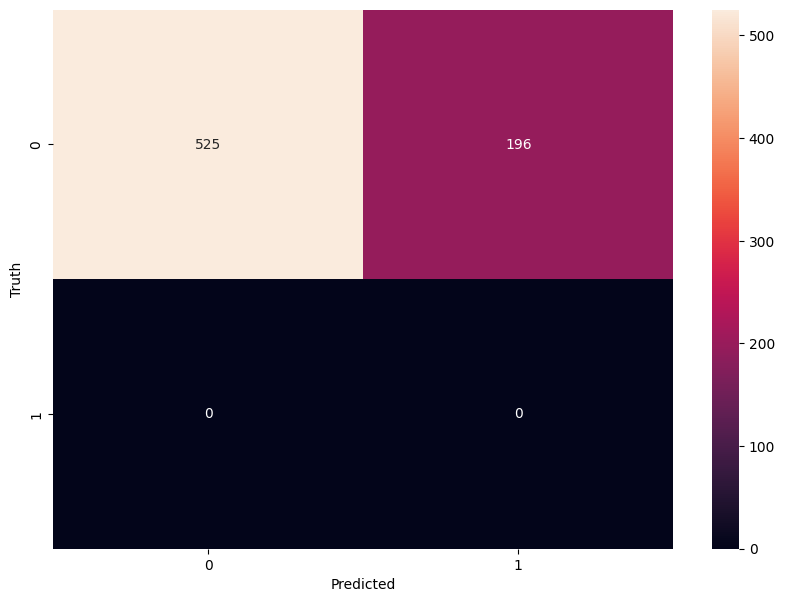

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf


import seaborn as sn
plt.figure(figsize = (10,7))
cnn = tf.math.confusion_matrix(labels=y_true1,predictions=y_pred1)

sn.heatmap(cnn, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')


In [ ]:
print(classification_report(y_true1,y_pred1))

              precision    recall  f1-score   support

           0       1.00      0.73      0.84       721
           1       0.00      0.00      0.00         0

    accuracy                           0.73       721
   macro avg       0.50      0.36      0.42       721
weighted avg       1.00      0.73      0.84       721



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import tensorflow as tf


# import seaborn as sn
# plt.figure(figsize = (10,7))
# cnn = tf.math.confusion_matrix(labels=y_true2,predictions=y_pred2)

# sn.heatmap(cnn, annot=True, fmt='d')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')



Non anomaly detection



In [ ]:
#del y_pred1
y_pred1=[]
#del y_pred2
y_pred2=[]

In [ ]:
num = len(uninfected_file_paths)


In [ ]:
#y_pred=encoder_model.predict_generator(anomaly_generator)
img_path=uninfected_file_paths
b=random.randint(0,len(uninfected_file_paths)-1)
for i in range(num):
#for i in range(40):
  print(i)
  test_anomaly(img_path[i])

0
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0038 - mse: 0.0038
1


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step - loss: 0.0048 - mse: 0.0048
2


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0049 - mse: 0.0049
3


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step - loss: 0.0025 - mse: 0.0025
4


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0030 - mse: 0.0030
5


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0032 - mse: 0.0032
6


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0045 - mse: 0.0045
7


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0036 - mse: 0.0036
8
1/1 [==============================] - 0s 22ms/step - loss: 0.0040 - mse: 0.0040
9


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step - loss: 0.0061 - mse: 0.0061
10
1/1 [==============================] - 0s 22ms/step - loss: 0.0048 - mse: 0.0048
11


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step - loss: 0.0027 - mse: 0.0027
12
1/1 [==============================] - 0s 23ms/step - loss: 0.0018 - mse: 0.0018
13


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0026 - mse: 0.0026
14
1/1 [==============================] - 0s 23ms/step - loss: 0.0022 - mse: 0.0022
15


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0033 - mse: 0.0033
16
1/1 [==============================] - 0s 29ms/step - loss: 0.0048 - mse: 0.0048
17


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0028 - mse: 0.0028
18
1/1 [==============================] - 0s 26ms/step - loss: 0.0045 - mse: 0.0045


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


19
1/1 [==============================] - 0s 39ms/step - loss: 0.0025 - mse: 0.0025


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


20
1/1 [==============================] - 0s 35ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0015 - mse: 0.0015
21
1/1 [==============================] - 0s 36ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step - loss: 0.0048 - mse: 0.0048
22
1/1 [==============================] - 0s 35ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0035 - mse: 0.0035
23
1/1 [==============================] - 0s 37ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 60ms/step - loss: 0.0019 - mse: 0.0019
24
1/1 [==============================] - 0s 37ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 44ms/step - loss: 0.0038 - mse: 0.0038
25
1/1 [==============================] - ETA: 0s

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step - loss: 0.0036 - mse: 0.0036
26
1/1 [==============================] - 0s 37ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step - loss: 0.0027 - mse: 0.0027
27
1/1 [==============================] - 0s 40ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0017 - mse: 0.0017
28
1/1 [==============================] - 0s 35ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0044 - mse: 0.0044
29
1/1 [==============================] - 0s 35ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0045 - mse: 0.0045
30
1/1 [==============================] - ETA: 0s

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0027 - mse: 0.0027
31
1/1 [==============================] - ETA: 0s

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0030 - mse: 0.0030
32
1/1 [==============================] - 0s 27ms/step - loss: 0.0032 - mse: 0.0032
33


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0046 - mse: 0.0046
34
1/1 [==============================] - 0s 33ms/step - loss: 0.0049 - mse: 0.0049


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


35
1/1 [==============================] - 0s 29ms/step - loss: 0.0021 - mse: 0.0021


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


36
1/1 [==============================] - ETA: 0s - loss: 0.0023 - mse: 0.0023

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0023 - mse: 0.0023
37
1/1 [==============================] - 0s 24ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0028 - mse: 0.0028
38
1/1 [==============================] - 0s 27ms/step - loss: 0.0038 - mse: 0.0038


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


39
1/1 [==============================] - 0s 30ms/step - loss: 0.0020 - mse: 0.0020


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


40
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0024 - mse: 0.0024
41
1/1 [==============================] - 0s 26ms/step - loss: 0.0036 - mse: 0.0036
42


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0037 - mse: 0.0037
43
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0031 - mse: 0.0031
44
1/1 [==============================] - 0s 25ms/step - loss: 0.0021 - mse: 0.0021


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


45
1/1 [==============================] - 0s 29ms/step - loss: 0.0033 - mse: 0.0033
46


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0052 - mse: 0.0052
47
1/1 [==============================] - 0s 27ms/step - loss: 0.0047 - mse: 0.0047
48


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0026 - mse: 0.0026
49
1/1 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0028

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0028 - mse: 0.0028
50
1/1 [==============================] - 0s 24ms/step - loss: 0.0044 - mse: 0.0044
51


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0020 - mse: 0.0020
52
1/1 [==============================] - 0s 26ms/step - loss: 0.0043 - mse: 0.0043
53


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0037 - mse: 0.0037
54
1/1 [==============================] - 0s 27ms/step - loss: 0.0032 - mse: 0.0032


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


55
1/1 [==============================] - 0s 27ms/step - loss: 0.0024 - mse: 0.0024


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


56
1/1 [==============================] - 0s 25ms/step - loss: 0.0048 - mse: 0.0048
57


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0041 - mse: 0.0041
58
1/1 [==============================] - 0s 26ms/step - loss: 0.0045 - mse: 0.0045


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


59
1/1 [==============================] - ETA: 0s - loss: 0.0031 - mse: 0.0031

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0031 - mse: 0.0031
60
1/1 [==============================] - 0s 24ms/step - loss: 0.0042 - mse: 0.0042


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


61
1/1 [==============================] - 0s 26ms/step - loss: 0.0033 - mse: 0.0033
62


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0024 - mse: 0.0024
63
1/1 [==============================] - 0s 23ms/step - loss: 0.0021 - mse: 0.0021
64


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0049 - mse: 0.0049
65
1/1 [==============================] - 0s 25ms/step - loss: 0.0031 - mse: 0.0031


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


66
1/1 [==============================] - 0s 27ms/step - loss: 0.0038 - mse: 0.0038
67


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0022 - mse: 0.0022
68
1/1 [==============================] - 0s 25ms/step - loss: 0.0034 - mse: 0.0034
69


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0037 - mse: 0.0037
70
1/1 [==============================] - 0s 28ms/step - loss: 0.0031 - mse: 0.0031
71


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0026 - mse: 0.0026
72
1/1 [==============================] - 0s 24ms/step - loss: 0.0015 - mse: 0.0015
73


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0029 - mse: 0.0029
74
1/1 [==============================] - 0s 32ms/step - loss: 0.0041 - mse: 0.0041
75


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0032

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0032 - mse: 0.0032
76
1/1 [==============================] - ETA: 0s - loss: 0.0037 - mse: 0.0037

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0037 - mse: 0.0037
77
1/1 [==============================] - 0s 26ms/step - loss: 0.0031 - mse: 0.0031
78


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0043 - mse: 0.0043
79
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0031 - mse: 0.0031
80
1/1 [==============================] - 0s 32ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step - loss: 0.0023 - mse: 0.0023
81
1/1 [==============================] - 0s 31ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0013 - mse: 0.0013
82
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0053 - mse: 0.0053
83
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step - loss: 0.0033 - mse: 0.0033
84
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0035 - mse: 0.0035
85
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0036 - mse: 0.0036
86
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0025 - mse: 0.0025
87
1/1 [==============================] - 0s 43ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step - loss: 0.0032 - mse: 0.0032
88
1/1 [==============================] - 0s 38ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step - loss: 0.0024 - mse: 0.0024
89
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 9.4449e-04 - mse: 9.4449e-04
90
1/1 [==============================] - 0s 32ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0038 - mse: 0.0038
91
1/1 [==============================] - 0s 34ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0033 - mse: 0.0033
92
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0014 - mse: 0.0014
93
1/1 [==============================] - 0s 31ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0026 - mse: 0.0026
94
1/1 [==============================] - 0s 25ms/step - loss: 0.0032 - mse: 0.0032


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


95
1/1 [==============================] - 0s 24ms/step - loss: 0.0036 - mse: 0.0036
96


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0035 - mse: 0.0035
97
1/1 [==============================] - 0s 26ms/step - loss: 0.0042 - mse: 0.0042


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


98
1/1 [==============================] - 0s 25ms/step - loss: 0.0043 - mse: 0.0043
99


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0042 - mse: 0.0042


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


100
1/1 [==============================] - 0s 25ms/step - loss: 0.0044 - mse: 0.0044


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


101
1/1 [==============================] - 0s 26ms/step - loss: 0.0024 - mse: 0.0024
102


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0027 - mse: 0.0027
103
1/1 [==============================] - 0s 24ms/step - loss: 0.0041 - mse: 0.0041


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


104
1/1 [==============================] - 0s 27ms/step - loss: 0.0042 - mse: 0.0042


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


105
1/1 [==============================] - 0s 24ms/step - loss: 0.0049 - mse: 0.0049


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


106
1/1 [==============================] - 0s 24ms/step - loss: 0.0020 - mse: 0.0020
107
1/1 [==============================] - 0s 23ms/step - loss: 0.0015 - mse: 0.0015


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


108
1/1 [==============================] - 0s 25ms/step - loss: 0.0045 - mse: 0.0045
109


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0018 - mse: 0.0018
110
1/1 [==============================] - 0s 26ms/step - loss: 0.0025 - mse: 0.0025
111


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0043 - mse: 0.0043
112
1/1 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0028

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0028 - mse: 0.0028
113
1/1 [==============================] - 0s 24ms/step - loss: 0.0042 - mse: 0.0042
114


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0041 - mse: 0.0041
115
1/1 [==============================] - 0s 26ms/step - loss: 0.0034 - mse: 0.0034


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


116
1/1 [==============================] - 0s 25ms/step - loss: 0.0031 - mse: 0.0031
117


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0043 - mse: 0.0043
118
1/1 [==============================] - 0s 26ms/step - loss: 0.0032 - mse: 0.0032


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


119
1/1 [==============================] - 0s 25ms/step - loss: 0.0035 - mse: 0.0035


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


120
1/1 [==============================] - 0s 26ms/step - loss: 0.0025 - mse: 0.0025


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


121
1/1 [==============================] - ETA: 0s - loss: 0.0023 - mse: 0.0023

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0023 - mse: 0.0023
122
1/1 [==============================] - ETA: 0s - loss: 0.0030 - mse: 0.0030

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0030 - mse: 0.0030
123
1/1 [==============================] - 0s 26ms/step - loss: 0.0037 - mse: 0.0037
124


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0027 - mse: 0.0027
125
1/1 [==============================] - 0s 27ms/step - loss: 0.0027 - mse: 0.0027
126


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0043 - mse: 0.0043
127
1/1 [==============================] - 0s 25ms/step - loss: 0.0044 - mse: 0.0044


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


128
1/1 [==============================] - 0s 26ms/step - loss: 0.0018 - mse: 0.0018
129


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0012 - mse: 0.0012
130
1/1 [==============================] - ETA: 0s - loss: 0.0022 - mse: 0.0022

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0022 - mse: 0.0022
131
1/1 [==============================] - 0s 27ms/step - loss: 0.0024 - mse: 0.0024
132


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0042 - mse: 0.0042
133
1/1 [==============================] - 0s 24ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0031 - mse: 0.0031
134
1/1 [==============================] - 0s 25ms/step - loss: 0.0051 - mse: 0.0051


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


135
1/1 [==============================] - 0s 25ms/step - loss: 0.0032 - mse: 0.0032
136


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0040 - mse: 0.0040
137
1/1 [==============================] - 0s 26ms/step - loss: 0.0027 - mse: 0.0027
138


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0020 - mse: 0.0020
139
1/1 [==============================] - 0s 23ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0034 - mse: 0.0034
140
1/1 [==============================] - 0s 26ms/step - loss: 0.0029 - mse: 0.0029
141


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0017 - mse: 0.0017
142
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step - loss: 0.0027 - mse: 0.0027
143
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step - loss: 0.0025 - mse: 0.0025
144
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0030 - mse: 0.0030
145
1/1 [==============================] - 0s 31ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0048 - mse: 0.0048
146
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step - loss: 0.0050 - mse: 0.0050
147
1/1 [==============================] - 0s 35ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0032 - mse: 0.0032
148
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0047 - mse: 0.0047
149
1/1 [==============================] - 0s 31ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step - loss: 0.0024 - mse: 0.0024
150
1/1 [==============================] - 0s 31ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0046 - mse: 0.0046
151
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0020 - mse: 0.0020
152
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0033 - mse: 0.0033
153
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0033 - mse: 0.0033
154
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step - loss: 0.0022 - mse: 0.0022
155
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0018 - mse: 0.0018
156
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0035 - mse: 0.0035
157
1/1 [==============================] - 0s 26ms/step - loss: 0.0043 - mse: 0.0043
158


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0038 - mse: 0.0038
159


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0025 - mse: 0.0025
160
1/1 [==============================] - 0s 27ms/step - loss: 0.0057 - mse: 0.0057


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


161
1/1 [==============================] - 0s 27ms/step - loss: 0.0042 - mse: 0.0042


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


162
1/1 [==============================] - 0s 25ms/step - loss: 0.0029 - mse: 0.0029
163
1/1 [==============================] - 0s 25ms/step - loss: 0.0033 - mse: 0.0033


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


164
1/1 [==============================] - 0s 22ms/step - loss: 0.0024 - mse: 0.0024


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


165
1/1 [==============================] - 0s 26ms/step - loss: 0.0038 - mse: 0.0038
166


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0029 - mse: 0.0029
167
1/1 [==============================] - ETA: 0s - loss: 0.0024 - mse: 0.0024

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0024 - mse: 0.0024
168
1/1 [==============================] - 0s 25ms/step - loss: 0.0032 - mse: 0.0032


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


169
1/1 [==============================] - 0s 25ms/step - loss: 0.0058 - mse: 0.0058


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


170
1/1 [==============================] - 0s 26ms/step - loss: 0.0028 - mse: 0.0028
171
1/1 [==============================] - 0s 25ms/step - loss: 0.0018 - mse: 0.0018
172


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0031 - mse: 0.0031
173
1/1 [==============================] - 0s 27ms/step - loss: 0.0027 - mse: 0.0027


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


174
1/1 [==============================] - ETA: 0s - loss: 0.0019 - mse: 0.0019

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0019 - mse: 0.0019
175
1/1 [==============================] - 0s 25ms/step - loss: 0.0023 - mse: 0.0023
176


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0019 - mse: 0.0019


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


177
1/1 [==============================] - 0s 26ms/step - loss: 0.0022 - mse: 0.0022
178


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0030 - mse: 0.0030
179
1/1 [==============================] - 0s 35ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0030 - mse: 0.0030
180
1/1 [==============================] - 0s 25ms/step - loss: 0.0016 - mse: 0.0016


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


181
1/1 [==============================] - 0s 24ms/step - loss: 0.0027 - mse: 0.0027
182
1/1 [==============================] - 0s 28ms/step - loss: 0.0022 - mse: 0.0022


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


183
1/1 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0032

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0032 - mse: 0.0032
184
1/1 [==============================] - 0s 25ms/step - loss: 0.0012 - mse: 0.0012
185


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0041 - mse: 0.0041
186
1/1 [==============================] - 0s 25ms/step - loss: 0.0043 - mse: 0.0043
187


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0043 - mse: 0.0043
188
1/1 [==============================] - 0s 35ms/step - loss: 0.0026 - mse: 0.0026


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


189
1/1 [==============================] - 0s 30ms/step - loss: 0.0036 - mse: 0.0036


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


190
1/1 [==============================] - 0s 25ms/step - loss: 0.0027 - mse: 0.0027


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


191
1/1 [==============================] - 0s 27ms/step - loss: 0.0035 - mse: 0.0035


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


192
1/1 [==============================] - 0s 26ms/step - loss: 0.0040 - mse: 0.0040
193


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0034 - mse: 0.0034
194
1/1 [==============================] - 0s 26ms/step - loss: 0.0021 - mse: 0.0021


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


195
1/1 [==============================] - ETA: 0s - loss: 0.0023 - mse: 0.0023

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0023 - mse: 0.0023
196
1/1 [==============================] - 0s 30ms/step - loss: 0.0033 - mse: 0.0033
197


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0052 - mse: 0.0052
198
1/1 [==============================] - 0s 30ms/step - loss: 0.0025 - mse: 0.0025


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


199
1/1 [==============================] - 0s 26ms/step - loss: 0.0035 - mse: 0.0035
200


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0044 - mse: 0.0044


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


201
1/1 [==============================] - 0s 27ms/step - loss: 0.0041 - mse: 0.0041
202


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0033 - mse: 0.0033


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


203
1/1 [==============================] - 0s 30ms/step - loss: 0.0015 - mse: 0.0015
204
1/1 [==============================] - ETA: 0s - loss: 0.0053 - mse: 0.0053

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0053 - mse: 0.0053
205
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0013 - mse: 0.0013
206
1/1 [==============================] - 0s 32ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0048 - mse: 0.0048
207
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0029 - mse: 0.0029
208
1/1 [==============================] - 0s 26ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0023 - mse: 0.0023
209
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0034 - mse: 0.0034
210
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0023 - mse: 0.0023
211
1/1 [==============================] - 0s 31ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0021 - mse: 0.0021
212
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0036 - mse: 0.0036
213
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0021 - mse: 0.0021
214
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0025 - mse: 0.0025
215
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0029 - mse: 0.0029
216
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step - loss: 0.0027 - mse: 0.0027
217
1/1 [==============================] - 0s 31ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0030 - mse: 0.0030
218
1/1 [==============================] - 0s 33ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 45ms/step - loss: 0.0016 - mse: 0.0016
219
1/1 [==============================] - 0s 23ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0018 - mse: 0.0018
220
1/1 [==============================] - 0s 22ms/step - loss: 0.0038 - mse: 0.0038
221


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0070 - mse: 0.0070
222
1/1 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0028

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0028 - mse: 0.0028
223
1/1 [==============================] - 0s 27ms/step - loss: 0.0044 - mse: 0.0044


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


224
1/1 [==============================] - ETA: 0s - loss: 0.0026 - mse: 0.0026

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0026 - mse: 0.0026
225
1/1 [==============================] - 0s 27ms/step - loss: 0.0037 - mse: 0.0037
226


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0020 - mse: 0.0020
227
1/1 [==============================] - 0s 24ms/step - loss: 0.0048 - mse: 0.0048


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


228
1/1 [==============================] - 0s 25ms/step - loss: 0.0044 - mse: 0.0044


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


229
1/1 [==============================] - 0s 26ms/step - loss: 0.0023 - mse: 0.0023
230


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0041 - mse: 0.0041
231
1/1 [==============================] - 0s 26ms/step - loss: 0.0037 - mse: 0.0037


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


232
1/1 [==============================] - ETA: 0s - loss: 0.0037 - mse: 0.0037

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0037 - mse: 0.0037
233
1/1 [==============================] - ETA: 0s - loss: 0.0027 - mse: 0.0027

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0027 - mse: 0.0027
234
1/1 [==============================] - ETA: 0s - loss: 0.0029 - mse: 0.0029

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0029 - mse: 0.0029
235
1/1 [==============================] - 0s 25ms/step - loss: 0.0024 - mse: 0.0024


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


236
1/1 [==============================] - 0s 28ms/step - loss: 0.0018 - mse: 0.0018
237
1/1 [==============================] - 0s 27ms/step - loss: 0.0022 - mse: 0.0022


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


238
1/1 [==============================] - 0s 27ms/step - loss: 0.0017 - mse: 0.0017
239


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0030 - mse: 0.0030


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


240
1/1 [==============================] - 0s 28ms/step - loss: 0.0034 - mse: 0.0034
241


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0030 - mse: 0.0030
242
1/1 [==============================] - 0s 25ms/step - loss: 0.0040 - mse: 0.0040
243


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0023 - mse: 0.0023
244
1/1 [==============================] - 0s 27ms/step - loss: 0.0017 - mse: 0.0017
245


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0034 - mse: 0.0034


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


246
1/1 [==============================] - 0s 26ms/step - loss: 0.0028 - mse: 0.0028


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


247
1/1 [==============================] - ETA: 0s - loss: 0.0036 - mse: 0.0036

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0036 - mse: 0.0036
248
1/1 [==============================] - 0s 26ms/step - loss: 0.0019 - mse: 0.0019


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


249
1/1 [==============================] - 0s 27ms/step - loss: 0.0050 - mse: 0.0050


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


250
1/1 [==============================] - 0s 26ms/step - loss: 0.0031 - mse: 0.0031
251
1/1 [==============================] - ETA: 0s - loss: 0.0020 - mse: 0.0020

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0020 - mse: 0.0020
252
1/1 [==============================] - 0s 28ms/step - loss: 0.0024 - mse: 0.0024


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


253
1/1 [==============================] - 0s 28ms/step - loss: 0.0029 - mse: 0.0029


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


254
1/1 [==============================] - ETA: 0s - loss: 0.0029 - mse: 0.0029

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0029 - mse: 0.0029
255
1/1 [==============================] - 0s 27ms/step - loss: 0.0035 - mse: 0.0035


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


256
1/1 [==============================] - 0s 31ms/step - loss: 0.0053 - mse: 0.0053


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


257
1/1 [==============================] - 0s 26ms/step - loss: 0.0047 - mse: 0.0047
258


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0033 - mse: 0.0033
259
1/1 [==============================] - 0s 27ms/step - loss: 0.0062 - mse: 0.0062
260


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0016 - mse: 0.0016
261
1/1 [==============================] - 0s 23ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0036 - mse: 0.0036
262
1/1 [==============================] - 0s 18ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step - loss: 0.0020 - mse: 0.0020
263
1/1 [==============================] - 0s 31ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0050 - mse: 0.0050
264
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0017 - mse: 0.0017
265
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0037 - mse: 0.0037
266
1/1 [==============================] - 0s 25ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0025 - mse: 0.0025
267
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0031 - mse: 0.0031
268
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0043 - mse: 0.0043
269
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 49ms/step - loss: 0.0049 - mse: 0.0049
270
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0027 - mse: 0.0027
271
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0026 - mse: 0.0026
272
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0039 - mse: 0.0039
273
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0033 - mse: 0.0033
274
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0065 - mse: 0.0065
275
1/1 [==============================] - 0s 33ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0033 - mse: 0.0033
276
1/1 [==============================] - 0s 47ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0042 - mse: 0.0042
277
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0028 - mse: 0.0028
278
1/1 [==============================] - 0s 31ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0037 - mse: 0.0037
279
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0041 - mse: 0.0041
280
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step - loss: 0.0031 - mse: 0.0031
281
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0025 - mse: 0.0025
282
1/1 [==============================] - 0s 29ms/step - loss: 0.0036 - mse: 0.0036


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


283
1/1 [==============================] - 0s 26ms/step - loss: 0.0049 - mse: 0.0049


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


284
1/1 [==============================] - 0s 26ms/step - loss: 0.0040 - mse: 0.0040


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


285
1/1 [==============================] - ETA: 0s - loss: 0.0030 - mse: 0.0030

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0030 - mse: 0.0030
286
1/1 [==============================] - 0s 24ms/step - loss: 0.0021 - mse: 0.0021


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


287
1/1 [==============================] - ETA: 0s - loss: 0.0026 - mse: 0.0026

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0026 - mse: 0.0026
288
1/1 [==============================] - 0s 25ms/step - loss: 0.0026 - mse: 0.0026


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


289
1/1 [==============================] - ETA: 0s - loss: 0.0029 - mse: 0.0029

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0029 - mse: 0.0029
290
1/1 [==============================] - ETA: 0s - loss: 0.0037 - mse: 0.0037

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0037 - mse: 0.0037
291
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0043 - mse: 0.0043
292
1/1 [==============================] - 0s 25ms/step - loss: 0.0018 - mse: 0.0018
293


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0041 - mse: 0.0041
294
1/1 [==============================] - 0s 24ms/step - loss: 0.0057 - mse: 0.0057


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


295
1/1 [==============================] - 0s 28ms/step - loss: 0.0045 - mse: 0.0045


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


296
1/1 [==============================] - 0s 27ms/step - loss: 0.0039 - mse: 0.0039


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


297
1/1 [==============================] - ETA: 0s - loss: 0.0030 - mse: 0.0030

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0030 - mse: 0.0030
298
1/1 [==============================] - ETA: 0s - loss: 0.0037 - mse: 0.0037

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0037 - mse: 0.0037
299
1/1 [==============================] - 0s 30ms/step - loss: 0.0020 - mse: 0.0020


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


300
1/1 [==============================] - ETA: 0s - loss: 0.0036 - mse: 0.0036

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0036 - mse: 0.0036
301
1/1 [==============================] - 0s 24ms/step - loss: 0.0034 - mse: 0.0034


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


302
1/1 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0032

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0032 - mse: 0.0032
303
1/1 [==============================] - 0s 25ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0027 - mse: 0.0027
304
1/1 [==============================] - 0s 24ms/step - loss: 0.0045 - mse: 0.0045


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


305
1/1 [==============================] - 0s 27ms/step - loss: 0.0027 - mse: 0.0027


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


306
1/1 [==============================] - 0s 27ms/step - loss: 0.0021 - mse: 0.0021


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


307
1/1 [==============================] - 0s 24ms/step - loss: 0.0020 - mse: 0.0020


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


308
1/1 [==============================] - ETA: 0s - loss: 0.0057 - mse: 0.0057

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0057 - mse: 0.0057


In [ ]:
print(len(y_pred1))
print(y_pred1)

309
[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]


In [ ]:
print(len(y_pred2))
print(y_pred2)

0
[]


In [ ]:
y_true1=[1]*len(y_pred1)
y_true2=[1]*len(y_pred2)

Text(95.72222222222221, 0.5, 'Truth')

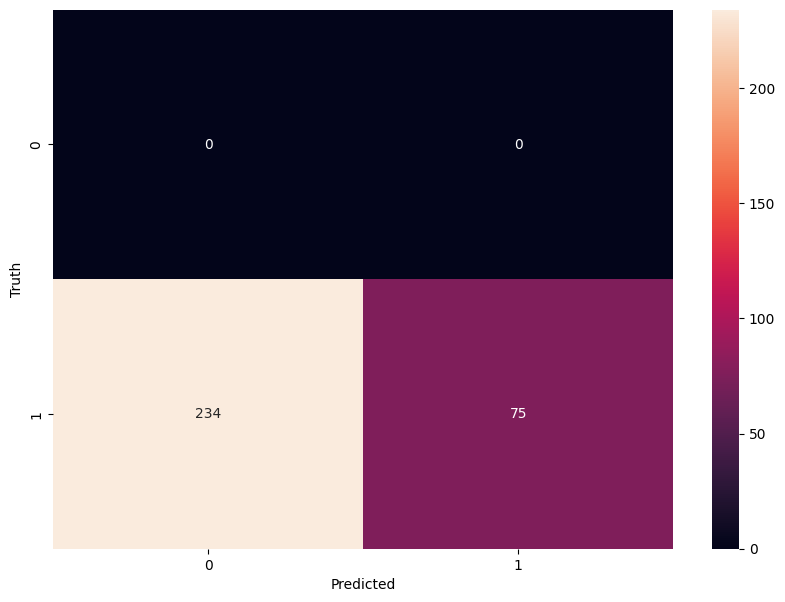

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf


import seaborn as sn
plt.figure(figsize = (10,7))
cnn = tf.math.confusion_matrix(labels=y_true1,predictions=y_pred1)

sn.heatmap(cnn, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')


In [ ]:
print(classification_report(y_true1,y_pred1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.24      0.39       309

    accuracy                           0.24       309
   macro avg       0.50      0.12      0.20       309
weighted avg       1.00      0.24      0.39       309



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
uninfected_file_paths = glob.glob('/content/drive/MyDrive/combined/Uninfected/new_uinfected/Test_3/images/*')

In [ ]:
#del y_pred1
y_pred1=[]
#del y_pred2
y_pred2=[]
num = len(uninfected_file_paths)


In [ ]:
#y_pred=encoder_model.predict_generator(anomaly_generator)
img_path=uninfected_file_paths
b=random.randint(0,len(uninfected_file_paths)-1)
for i in range(num):
#for i in range(40):
  print(i)
  test_anomaly(img_path[i])

0
1/1 [==============================] - 0s 31ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0024 - mse: 0.0024
1
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0017 - mse: 0.0017
2
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0043 - mse: 0.0043
3
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step - loss: 0.0041 - mse: 0.0041
4
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0048 - mse: 0.0048
5
1/1 [==============================] - 0s 24ms/step - loss: 0.0022 - mse: 0.0022


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


6
1/1 [==============================] - 0s 26ms/step - loss: 0.0038 - mse: 0.0038
7


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0052 - mse: 0.0052
8
1/1 [==============================] - 0s 26ms/step - loss: 0.0038 - mse: 0.0038
9


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0037 - mse: 0.0037
10
1/1 [==============================] - 0s 23ms/step - loss: 0.0025 - mse: 0.0025
11


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0013 - mse: 0.0013
12
1/1 [==============================] - 0s 25ms/step - loss: 0.0049 - mse: 0.0049
13


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0036 - mse: 0.0036
14
1/1 [==============================] - 0s 26ms/step - loss: 0.0024 - mse: 0.0024


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


15
1/1 [==============================] - 0s 25ms/step - loss: 0.0033 - mse: 0.0033
16


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0037 - mse: 0.0037
17
1/1 [==============================] - ETA: 0s - loss: 0.0040 - mse: 0.0040

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0040 - mse: 0.0040
18
1/1 [==============================] - 0s 24ms/step - loss: 0.0026 - mse: 0.0026
19


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0027 - mse: 0.0027
20
1/1 [==============================] - 0s 25ms/step - loss: 0.0020 - mse: 0.0020


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


21
1/1 [==============================] - 0s 24ms/step - loss: 0.0013 - mse: 0.0013
22


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0025 - mse: 0.0025
23
1/1 [==============================] - 0s 25ms/step - loss: 0.0035 - mse: 0.0035
24


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0031 - mse: 0.0031
25
1/1 [==============================] - 0s 24ms/step - loss: 0.0034 - mse: 0.0034
26


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0044 - mse: 0.0044
27
1/1 [==============================] - 0s 24ms/step - loss: 0.0033 - mse: 0.0033
28


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0038 - mse: 0.0038
29
1/1 [==============================] - 0s 24ms/step - loss: 0.0038 - mse: 0.0038
30


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step - loss: 0.0044 - mse: 0.0044
31
1/1 [==============================] - 0s 23ms/step - loss: 0.0027 - mse: 0.0027
32


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0029 - mse: 0.0029
33
1/1 [==============================] - 0s 24ms/step - loss: 0.0024 - mse: 0.0024
34


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0027 - mse: 0.0027
35
1/1 [==============================] - 0s 21ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0012 - mse: 0.0012
36
1/1 [==============================] - 0s 23ms/step - loss: 0.0022 - mse: 0.0022
37


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0018 - mse: 0.0018
38
1/1 [==============================] - 0s 25ms/step - loss: 0.0034 - mse: 0.0034
39


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0024 - mse: 0.0024
40
1/1 [==============================] - 0s 23ms/step - loss: 0.0022 - mse: 0.0022
41


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0027 - mse: 0.0027
42
1/1 [==============================] - 0s 26ms/step - loss: 0.0030 - mse: 0.0030
43


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0024 - mse: 0.0024
44
1/1 [==============================] - 0s 27ms/step - loss: 0.0030 - mse: 0.0030


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


45
1/1 [==============================] - 0s 25ms/step - loss: 0.0024 - mse: 0.0024
46
1/1 [==============================] - 0s 25ms/step - loss: 0.0027 - mse: 0.0027
47


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0015 - mse: 0.0015
48
1/1 [==============================] - 0s 25ms/step - loss: 0.0032 - mse: 0.0032
49


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0049 - mse: 0.0049
50


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0025 - mse: 0.0025
51
1/1 [==============================] - 0s 24ms/step - loss: 0.0022 - mse: 0.0022
52


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0032 - mse: 0.0032
53
1/1 [==============================] - 0s 25ms/step - loss: 0.0036 - mse: 0.0036
54


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0043 - mse: 0.0043
55


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0030 - mse: 0.0030
56
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0031 - mse: 0.0031
57
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 48ms/step - loss: 0.0031 - mse: 0.0031
58
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0029 - mse: 0.0029
59
1/1 [==============================] - 0s 40ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0027 - mse: 0.0027
60
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0032 - mse: 0.0032
61
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0046 - mse: 0.0046
62
1/1 [==============================] - 0s 31ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0018 - mse: 0.0018
63
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0024 - mse: 0.0024
64
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0031 - mse: 0.0031
65
1/1 [==============================] - 0s 37ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0043 - mse: 0.0043
66
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0040 - mse: 0.0040
67
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0017 - mse: 0.0017
68
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0036 - mse: 0.0036
69
1/1 [==============================] - 0s 26ms/step - loss: 0.0015 - mse: 0.0015
70


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0022 - mse: 0.0022
71


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0025 - mse: 0.0025
72
1/1 [==============================] - 0s 25ms/step - loss: 0.0030 - mse: 0.0030
73


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0026 - mse: 0.0026
74


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0033 - mse: 0.0033
75
1/1 [==============================] - 0s 26ms/step - loss: 0.0043 - mse: 0.0043
76


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0023 - mse: 0.0023
77
1/1 [==============================] - 0s 24ms/step - loss: 0.0043 - mse: 0.0043


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


78
1/1 [==============================] - 0s 22ms/step - loss: 0.0037 - mse: 0.0037
79


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step - loss: 0.0033 - mse: 0.0033
80
1/1 [==============================] - 0s 25ms/step - loss: 0.0018 - mse: 0.0018


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


81
1/1 [==============================] - 0s 23ms/step - loss: 0.0027 - mse: 0.0027
82


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0031 - mse: 0.0031
83
1/1 [==============================] - 0s 26ms/step - loss: 0.0050 - mse: 0.0050


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


84
1/1 [==============================] - 0s 22ms/step - loss: 0.0033 - mse: 0.0033
85
1/1 [==============================] - 0s 22ms/step - loss: 0.0035 - mse: 0.0035
86


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0031 - mse: 0.0031
87
1/1 [==============================] - 0s 22ms/step - loss: 0.0045 - mse: 0.0045
88


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0020 - mse: 0.0020
89
1/1 [==============================] - 0s 25ms/step - loss: 0.0023 - mse: 0.0023
90


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step - loss: 0.0037 - mse: 0.0037
91
1/1 [==============================] - 0s 22ms/step - loss: 0.0032 - mse: 0.0032
92


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step - loss: 0.0036 - mse: 0.0036
93
1/1 [==============================] - 0s 23ms/step - loss: 0.0025 - mse: 0.0025
94


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0037 - mse: 0.0037
95
1/1 [==============================] - 0s 26ms/step - loss: 0.0038 - mse: 0.0038


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


96
1/1 [==============================] - 0s 25ms/step - loss: 0.0018 - mse: 0.0018
97


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0023 - mse: 0.0023
98
1/1 [==============================] - 0s 25ms/step - loss: 0.0025 - mse: 0.0025
99


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0032 - mse: 0.0032
100
1/1 [==============================] - 0s 23ms/step - loss: 0.0034 - mse: 0.0034
101


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0042 - mse: 0.0042
102
1/1 [==============================] - 0s 27ms/step - loss: 0.0028 - mse: 0.0028
103


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step - loss: 0.0030 - mse: 0.0030
104


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0045 - mse: 0.0045
105
1/1 [==============================] - 0s 23ms/step - loss: 0.0028 - mse: 0.0028
106


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 21ms/step - loss: 0.0020 - mse: 0.0020
107
1/1 [==============================] - 0s 23ms/step - loss: 0.0027 - mse: 0.0027
108


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0029 - mse: 0.0029
109
1/1 [==============================] - 0s 21ms/step - loss: 0.0024 - mse: 0.0024
110


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0035 - mse: 0.0035
111
1/1 [==============================] - 0s 29ms/step - loss: 0.0044 - mse: 0.0044
112


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0035 - mse: 0.0035
113
1/1 [==============================] - 0s 24ms/step - loss: 0.0020 - mse: 0.0020
114


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0026 - mse: 0.0026
115
1/1 [==============================] - 0s 22ms/step - loss: 0.0025 - mse: 0.0025
116


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step - loss: 0.0015 - mse: 0.0015
117
1/1 [==============================] - 0s 22ms/step - loss: 0.0036 - mse: 0.0036
118


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0021 - mse: 0.0021
119
1/1 [==============================] - 0s 23ms/step - loss: 0.0034 - mse: 0.0034
120


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step - loss: 0.0012 - mse: 0.0012
121
1/1 [==============================] - 0s 37ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0018 - mse: 0.0018
122
1/1 [==============================] - 0s 36ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0019 - mse: 0.0019
123
1/1 [==============================] - 0s 26ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0025 - mse: 0.0025
124
1/1 [==============================] - 0s 26ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0033 - mse: 0.0033
125
1/1 [==============================] - 0s 26ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0018 - mse: 0.0018
126
1/1 [==============================] - 0s 26ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0023 - mse: 0.0023
127
1/1 [==============================] - 0s 34ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0036 - mse: 0.0036
128
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0041 - mse: 0.0041
129
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0041 - mse: 0.0041
130
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0039 - mse: 0.0039
131
1/1 [==============================] - 0s 30ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0043 - mse: 0.0043
132
1/1 [==============================] - 0s 29ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0035 - mse: 0.0035
133
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0019 - mse: 0.0019
134
1/1 [==============================] - 0s 28ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0031 - mse: 0.0031
135
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step - loss: 0.0028 - mse: 0.0028
136
1/1 [==============================] - 0s 23ms/step - loss: 0.0041 - mse: 0.0041
137


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 22ms/step - loss: 0.0042 - mse: 0.0042
138
1/1 [==============================] - 0s 21ms/step - loss: 0.0029 - mse: 0.0029
139


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0035 - mse: 0.0035
140
1/1 [==============================] - 0s 23ms/step - loss: 0.0028 - mse: 0.0028
141


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step - loss: 0.0041 - mse: 0.0041
142
1/1 [==============================] - 0s 22ms/step - loss: 0.0023 - mse: 0.0023
143


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step - loss: 0.0027 - mse: 0.0027
144
1/1 [==============================] - 0s 22ms/step - loss: 0.0024 - mse: 0.0024
145


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0053 - mse: 0.0053
146
1/1 [==============================] - 0s 24ms/step - loss: 0.0020 - mse: 0.0020
147


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step - loss: 0.0028 - mse: 0.0028
148
1/1 [==============================] - 0s 25ms/step - loss: 0.0016 - mse: 0.0016
149


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 24ms/step - loss: 0.0016 - mse: 0.0016
150
1/1 [==============================] - 0s 25ms/step - loss: 0.0021 - mse: 0.0021
151


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 23ms/step - loss: 0.0031 - mse: 0.0031
152
1/1 [==============================] - 0s 24ms/step - loss: 0.0057 - mse: 0.0057
153


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0029 - mse: 0.0029
154
1/1 [==============================] - 0s 26ms/step - loss: 0.0033 - mse: 0.0033
155


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0049 - mse: 0.0049
156
1/1 [==============================] - 0s 25ms/step - loss: 0.0027 - mse: 0.0027


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


157
1/1 [==============================] - 0s 26ms/step - loss: 0.0045 - mse: 0.0045
158


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0042 - mse: 0.0042
159
1/1 [==============================] - 0s 24ms/step - loss: 0.0045 - mse: 0.0045


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


160
1/1 [==============================] - 0s 26ms/step - loss: 0.0046 - mse: 0.0046
161


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0033 - mse: 0.0033


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


162
1/1 [==============================] - 0s 24ms/step - loss: 0.0043 - mse: 0.0043


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


163
1/1 [==============================] - 0s 27ms/step - loss: 0.0031 - mse: 0.0031
164


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 25ms/step - loss: 0.0038 - mse: 0.0038


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


165
1/1 [==============================] - 0s 27ms/step - loss: 0.0038 - mse: 0.0038
166
1/1 [==============================] - 0s 26ms/step - loss: 0.0042 - mse: 0.0042


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


167
1/1 [==============================] - 0s 26ms/step - loss: 0.0028 - mse: 0.0028


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


168
1/1 [==============================] - ETA: 0s - loss: 0.0041 - mse: 0.0041

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 27ms/step - loss: 0.0041 - mse: 0.0041
169
1/1 [==============================] - 0s 25ms/step - loss: 0.0033 - mse: 0.0033


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


170
1/1 [==============================] - 0s 27ms/step - loss: 0.0035 - mse: 0.0035


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


171
1/1 [==============================] - 0s 21ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0033 - mse: 0.0033
172
1/1 [==============================] - 0s 25ms/step - loss: 0.0039 - mse: 0.0039


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


173
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0034 - mse: 0.0034
174
1/1 [==============================] - ETA: 0s - loss: 0.0021 - mse: 0.0021

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0021 - mse: 0.0021
175
1/1 [==============================] - ETA: 0s - loss: 0.0025 - mse: 0.0025

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0025 - mse: 0.0025
176
1/1 [==============================] - ETA: 0s - loss: 0.0036 - mse: 0.0036

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 36ms/step - loss: 0.0036 - mse: 0.0036
177
1/1 [==============================] - 0s 25ms/step - loss: 0.0026 - mse: 0.0026


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


178
1/1 [==============================] - 0s 24ms/step - loss: 0.0029 - mse: 0.0029
179


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 26ms/step - loss: 0.0026 - mse: 0.0026
180
1/1 [==============================] - 0s 23ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0023 - mse: 0.0023
181
1/1 [==============================] - 0s 27ms/step - loss: 0.0027 - mse: 0.0027
182


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))
<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0034 - mse: 0.0034
183
1/1 [==============================] - 0s 20ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 41ms/step - loss: 0.0037 - mse: 0.0037
184
1/1 [==============================] - 0s 34ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 42ms/step - loss: 0.0037 - mse: 0.0037
185
1/1 [==============================] - ETA: 0s

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0033 - mse: 0.0033
186
1/1 [==============================] - 0s 47ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 39ms/step - loss: 0.0026 - mse: 0.0026
187
1/1 [==============================] - 0s 44ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 43ms/step - loss: 0.0032 - mse: 0.0032
188
1/1 [==============================] - 0s 39ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 40ms/step - loss: 0.0020 - mse: 0.0020
189
1/1 [==============================] - 0s 36ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 55ms/step - loss: 0.0018 - mse: 0.0018
190
1/1 [==============================] - 0s 34ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0017 - mse: 0.0017
191
1/1 [==============================] - 0s 35ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0017 - mse: 0.0017
192
1/1 [==============================] - 0s 35ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 37ms/step - loss: 0.0025 - mse: 0.0025
193
1/1 [==============================] - 0s 35ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 46ms/step - loss: 0.0024 - mse: 0.0024
194
1/1 [==============================] - 0s 54ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0023 - mse: 0.0023
195
1/1 [==============================] - 0s 25ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0032 - mse: 0.0032
196
1/1 [==============================] - 0s 35ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0015 - mse: 0.0015
197
1/1 [==============================] - 0s 27ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0023 - mse: 0.0023
198
1/1 [==============================] - 0s 24ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0014 - mse: 0.0014
199
1/1 [==============================] - 0s 24ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0022 - mse: 0.0022
200
1/1 [==============================] - ETA: 0s - loss: 0.0027 - mse: 0.0027

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 29ms/step - loss: 0.0027 - mse: 0.0027
201
1/1 [==============================] - 0s 26ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0021 - mse: 0.0021
202
1/1 [==============================] - 0s 24ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 38ms/step - loss: 0.0019 - mse: 0.0019
203
1/1 [==============================] - ETA: 0s - loss: 0.0027 - mse: 0.0027

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 28ms/step - loss: 0.0027 - mse: 0.0027
204
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0022 - mse: 0.0022
205
1/1 [==============================] - 0s 24ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0029 - mse: 0.0029
206
1/1 [==============================] - 0s 29ms/step - loss: 0.0020 - mse: 0.0020


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


207
1/1 [==============================] - 0s 23ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 30ms/step - loss: 0.0024 - mse: 0.0024
208
1/1 [==============================] - ETA: 0s - loss: 0.0031 - mse: 0.0031

<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 33ms/step - loss: 0.0031 - mse: 0.0031
209
1/1 [==============================] - 0s 26ms/step - loss: 0.0027 - mse: 0.0027


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


210
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 35ms/step - loss: 0.0027 - mse: 0.0027
211
1/1 [==============================] - 0s 22ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 32ms/step - loss: 0.0030 - mse: 0.0030
212
1/1 [==============================] - 0s 27ms/step - loss: 0.0020 - mse: 0.0020


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


213
1/1 [==============================] - 0s 19ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 31ms/step - loss: 0.0042 - mse: 0.0042
214
1/1 [==============================] - 0s 33ms/step


<ipython-input-20-d1cac28c88f2>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = np.array(img.resize((128,128), Image.ANTIALIAS))


1/1 [==============================] - 0s 34ms/step - loss: 0.0029 - mse: 0.0029


In [ ]:
print(len(y_pred1))
print(y_pred1)

215
[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1]


In [ ]:
print(len(y_pred2))
print(y_pred2)

0
[]


In [ ]:
y_true1=[1]*len(y_pred1)
y_true2=[1]*len(y_pred2)

Text(95.72222222222221, 0.5, 'Truth')

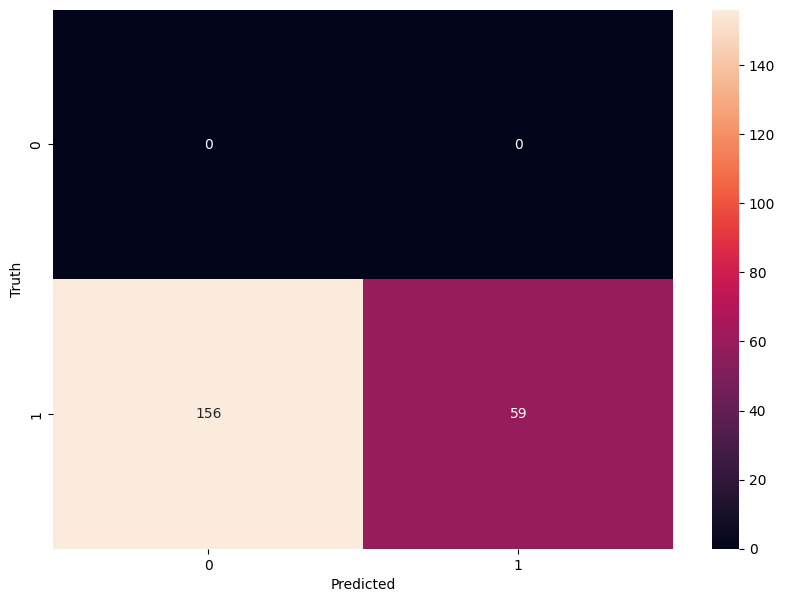

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf


import seaborn as sn
plt.figure(figsize = (10,7))
cnn = tf.math.confusion_matrix(labels=y_true1,predictions=y_pred1)

sn.heatmap(cnn, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')


In [ ]:
print(classification_report(y_true1,y_pred1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.27      0.43       215

    accuracy                           0.27       215
   macro avg       0.50      0.14      0.22       215
weighted avg       1.00      0.27      0.43       215



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
